<a href="https://colab.research.google.com/github/richardggx94/Mindbody-Assignment/blob/main/Mindbody_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Diff-in-diff Promotion Impact on Class Awareness (Pack Views)**

In [ ]:
"""
Difference-in-Differences Analysis: Impact of Price Reduction on Pack Views
Student Name: [Your Name]
Date: [Current Date]
Course: [Course Name/Number]

Purpose: This analysis examines the causal effect of a promotional price reduction
on product visibility (pack views) using a Difference-in-Differences methodology
with clustered standard errors to account for company-level correlation.
"""

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.power as smp

# ==========================================
# SECTION 1: DATA IMPORT AND PREPARATION
# ==========================================

# Load the dataset
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

print(f"Dataset successfully loaded: {len(df)} observations")

# Standardize column names for consistency
# This converts spaces to underscores and makes all names lowercase
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Create binary indicators for regression analysis
# Period: Pre-promotion (0) vs Post-promotion (1)
# Test Cohort: Control group (0) vs Test group (1)
df['period_numeric'] = df['period'].map({'Pre': 0, 'Post': 1})
df['test_numeric'] = df['test_cohort'].map({'Control': 0, 'Test': 1})

# Display data structure
print(f"\nData Structure by Period and Cohort:")
print(df.groupby(['period', 'test_cohort']).size())

# ==========================================
# SECTION 2: DESCRIPTIVE STATISTICS
# ==========================================

print("\n" + "="*60)
print("DESCRIPTIVE ANALYSIS: PACK VIEWS BY GROUP AND PERIOD")
print("="*60)

# Calculate mean pack views for each group-period combination
group_means = df.groupby(['test_cohort', 'period'])['pack_views'].mean().unstack()
print("\nMean Pack Views Summary:")
print(group_means.round(2))

# Manual calculation of Difference-in-Differences
# This helps verify the regression results
control_change = group_means.loc['Control', 'Post'] - group_means.loc['Control', 'Pre']
test_change = group_means.loc['Test', 'Post'] - group_means.loc['Test', 'Pre']
did_estimate = test_change - control_change

print(f"\nDifference-in-Differences Decomposition:")
print(f"Control Group Change (Post - Pre): {control_change:,.2f}")
print(f"Test Group Change (Post - Pre): {test_change:,.2f}")
print(f"DiD Estimate (Test Change - Control Change): {did_estimate:,.2f}")

# ==========================================
# SECTION 3: REGRESSION ANALYSIS
# ==========================================

print("\n" + "="*60)
print("REGRESSION ANALYSIS WITH CLUSTERED STANDARD ERRORS")
print("="*60)

# Specify the DiD regression model
# pack_views = β₀ + β₁(period) + β₂(test) + β₃(period × test) + ε
# The interaction term β₃ captures the causal effect
regression_formula = 'pack_views ~ period_numeric * test_numeric'

# Estimate model with cluster-robust standard errors
# Clustering by company_id accounts for within-company correlation
model_clustered = smf.ols(formula=regression_formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['company_id']}
)

# Display regression results
print(model_clustered.summary())

# ==========================================
# SECTION 4: INTERPRETATION OF RESULTS
# ==========================================

print("\n" + "="*60)
print("ANALYSIS OF TREATMENT EFFECT")
print("="*60)

# Extract the interaction coefficient (DiD estimator)
treatment_effect = model_clustered.params['period_numeric:test_numeric']
standard_error = model_clustered.bse['period_numeric:test_numeric']
p_value = model_clustered.pvalues['period_numeric:test_numeric']
confidence_interval = model_clustered.conf_int().loc['period_numeric:test_numeric']

# Present key findings
print(f"\nTreatment Effect Estimate:")
print(f"Coefficient: {treatment_effect:,.2f} pack views")
print(f"Standard Error (Clustered): {standard_error:,.2f}")
print(f"t-statistic: {treatment_effect/standard_error:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"95% Confidence Interval: [{confidence_interval[0]:,.2f}, {confidence_interval[1]:,.2f}]")

# Statistical significance interpretation
significance_level = 0.05
if p_value < significance_level:
    if treatment_effect > 0:
        conclusion = "The promotion significantly increased pack views"
    else:
        conclusion = "The promotion significantly decreased pack views"
else:
    conclusion = "The promotion had no statistically significant effect on pack views"

print(f"\nConclusion: {conclusion}")

# ==========================================
# SECTION 5: ROBUSTNESS CHECK
# ==========================================

print("\n" + "="*60)
print("ROBUSTNESS CHECK: CLUSTERED VS. NON-CLUSTERED STANDARD ERRORS")
print("="*60)

# Estimate the same model without clustering for comparison
model_simple = smf.ols(formula=regression_formula, data=df).fit()

# Compare standard errors
comparison_results = pd.DataFrame({
    'Coefficient': [treatment_effect, treatment_effect],
    'Standard Error': [
        model_simple.bse['period_numeric:test_numeric'],
        standard_error
    ],
    'P-value': [
        model_simple.pvalues['period_numeric:test_numeric'],
        p_value
    ]
}, index=['Non-Clustered', 'Clustered by Company ID'])

print(comparison_results.round(4))

# ==========================================
# SECTION 6: STATISTICAL POWER ANALYSIS
# ==========================================

print("\n" + "="*60)
print("STATISTICAL POWER ANALYSIS")
print("="*60)

# Calculate components for power analysis
residual_std_dev = np.sqrt(model_clustered.mse_resid)
total_observations = len(df)
obs_per_group = total_observations / 4  # 2x2 design

# Compute effect size (Cohen's d)
cohen_d = treatment_effect / residual_std_dev

# Post-hoc power calculation
observed_power = smp.ttest_power(
    cohen_d,
    nobs=obs_per_group,
    alpha=0.05
)

print(f"\nPower Analysis Results:")
print(f"Observed Effect Size (Cohen's d): {cohen_d:.3f}")
print(f"Statistical Power: {observed_power:.1%}")

# Minimum Detectable Effect at 80% power
mde_cohen = smp.tt_ind_solve_power(
    nobs1=obs_per_group,
    alpha=0.05,
    power=0.80
)
mde_views = mde_cohen * residual_std_dev

print(f"\nMinimum Detectable Effect (80% power): {mde_views:,.0f} views")
print(f"Observed Effect: {abs(treatment_effect):,.0f} views")

# Sample size requirements
if cohen_d != 0:
    required_n_per_group = smp.tt_ind_solve_power(
        effect_size=abs(cohen_d),
        alpha=0.05,
        power=0.80
    )
    required_total = required_n_per_group * 4

    print(f"\nSample Size Analysis:")
    print(f"Current sample size: {total_observations}")
    print(f"Required for 80% power: {required_total:.0f}")

# ==========================================
# SECTION 7: DATA QUALITY ASSESSMENT
# ==========================================

print("\n" + "="*60)
print("DATA QUALITY: PANEL BALANCE CHECK")
print("="*60)

# Identify companies observed in both periods
companies_per_period = df.groupby('company_id')['period'].nunique()
balanced_companies = companies_per_period[companies_per_period == 2].index
num_balanced = len(balanced_companies)
total_companies = df['company_id'].nunique()

print(f"Panel Balance Summary:")
print(f"Total unique companies: {total_companies}")
print(f"Companies in both periods: {num_balanced}")
print(f"Balance rate: {num_balanced/total_companies:.1%}")

# If panel is unbalanced, show results for balanced subset
if num_balanced < total_companies:
    print("\nNote: Panel is unbalanced. Some companies appear in only one period.")

    # Re-estimate for balanced panel
    balanced_data = df[df['company_id'].isin(balanced_companies)]
    balanced_means = balanced_data.groupby(['test_cohort', 'period'])['pack_views'].mean().unstack()

    print("\nBalanced Panel Results:")
    print(balanced_means.round(2))

# ==========================================
# END OF ANALYSIS
# ==========================================

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

Dataset successfully loaded: 400 observations

Data Structure by Period and Cohort:
period  test_cohort
Post    Control        100
        Test           100
Pre     Control        100
        Test           100
dtype: int64

DESCRIPTIVE ANALYSIS: PACK VIEWS BY GROUP AND PERIOD

Mean Pack Views Summary:
period          Post      Pre
test_cohort                  
Control      4923.05  4834.51
Test         6321.38  5594.84

Difference-in-Differences Decomposition:
Control Group Change (Post - Pre): 88.54
Test Group Change (Post - Pre): 726.54
DiD Estimate (Test Change - Control Change): 638.00

REGRESSION ANALYSIS WITH CLUSTERED STANDARD ERRORS
                            OLS Regression Results                            
Dep. Variable:             pack_views   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     111.1
Date:                Thu, 24 Jul 

## **Diff-in-diff Promotion Impact on Class Demand (Purchases)**

In [ ]:
"""
Difference-in-Differences Analysis: Impact of Price Reduction on Purchases
Student Name: [Your Name]
Date: [Current Date]
Course: [Course Name/Number]

Purpose: This analysis examines the causal effect of a promotional price reduction
on product purchases using a Difference-in-Differences methodology with clustered
standard errors to account for company-level correlation. The analysis focuses
solely on the treatment effect without controlling for other factors.
"""

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.power as smp

# ==========================================
# SECTION 1: DATA IMPORT AND PREPARATION
# ==========================================

# Load the dataset
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

print(f"Dataset successfully loaded: {len(df)} observations")

# Standardize column names for consistency
# This converts spaces to underscores and makes all names lowercase
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Create binary indicators for regression analysis
# Period: Pre-promotion (0) vs Post-promotion (1)
# Test Cohort: Control group (0) vs Test group (1)
df['period_numeric'] = df['period'].map({'Pre': 0, 'Post': 1})
df['test_numeric'] = df['test_cohort'].map({'Control': 0, 'Test': 1})

# Display data structure
print(f"\nData Structure by Period and Cohort:")
print(df.groupby(['period', 'test_cohort']).size())

# ==========================================
# SECTION 2: DESCRIPTIVE STATISTICS
# ==========================================

print("\n" + "="*60)
print("DESCRIPTIVE ANALYSIS: PURCHASES BY GROUP AND PERIOD")
print("="*60)

# Calculate mean purchases for each group-period combination
group_means = df.groupby(['test_cohort', 'period'])['purchases'].mean().unstack()
print("\nMean Purchases Summary:")
print(group_means.round(2))

# Manual calculation of Difference-in-Differences
# This helps verify the regression results
control_change = group_means.loc['Control', 'Post'] - group_means.loc['Control', 'Pre']
test_change = group_means.loc['Test', 'Post'] - group_means.loc['Test', 'Pre']
did_estimate = test_change - control_change

print(f"\nDifference-in-Differences Decomposition:")
print(f"Control Group Change (Post - Pre): {control_change:,.2f}")
print(f"Test Group Change (Post - Pre): {test_change:,.2f}")
print(f"DiD Estimate (Test Change - Control Change): {did_estimate:,.2f}")

# ==========================================
# SECTION 3: REGRESSION ANALYSIS
# ==========================================

print("\n" + "="*60)
print("REGRESSION ANALYSIS WITH CLUSTERED STANDARD ERRORS")
print("="*60)

# Specify the DiD regression model
# purchases = β₀ + β₁(period) + β₂(test) + β₃(period × test) + ε
# The interaction term β₃ captures the causal effect
regression_formula = 'purchases ~ period_numeric * test_numeric'

# Estimate model with cluster-robust standard errors
# Clustering by company_id accounts for within-company correlation
model_clustered = smf.ols(formula=regression_formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['company_id']}
)

# Display regression results
print(model_clustered.summary())

# ==========================================
# SECTION 4: INTERPRETATION OF RESULTS
# ==========================================

print("\n" + "="*60)
print("ANALYSIS OF TREATMENT EFFECT")
print("="*60)

# Extract the interaction coefficient (DiD estimator)
treatment_effect = model_clustered.params['period_numeric:test_numeric']
standard_error = model_clustered.bse['period_numeric:test_numeric']
p_value = model_clustered.pvalues['period_numeric:test_numeric']
confidence_interval = model_clustered.conf_int().loc['period_numeric:test_numeric']

# Present key findings
print(f"\nTreatment Effect Estimate:")
print(f"Coefficient: {treatment_effect:,.2f} purchases")
print(f"Standard Error (Clustered): {standard_error:,.2f}")
print(f"t-statistic: {treatment_effect/standard_error:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"95% Confidence Interval: [{confidence_interval[0]:,.2f}, {confidence_interval[1]:,.2f}]")

# Statistical significance interpretation
significance_level = 0.05
if p_value < significance_level:
    if treatment_effect > 0:
        conclusion = "The promotion significantly increased purchases"
    else:
        conclusion = "The promotion significantly decreased purchases"
else:
    conclusion = "The promotion had no statistically significant effect on purchases"

print(f"\nConclusion: {conclusion}")

# ==========================================
# SECTION 5: ROBUSTNESS CHECK
# ==========================================

print("\n" + "="*60)
print("ROBUSTNESS CHECK: CLUSTERED VS. NON-CLUSTERED STANDARD ERRORS")
print("="*60)

# Estimate the same model without clustering for comparison
model_simple = smf.ols(formula=regression_formula, data=df).fit()

# Compare standard errors
comparison_results = pd.DataFrame({
    'Coefficient': [treatment_effect, treatment_effect],
    'Standard Error': [
        model_simple.bse['period_numeric:test_numeric'],
        standard_error
    ],
    'P-value': [
        model_simple.pvalues['period_numeric:test_numeric'],
        p_value
    ]
}, index=['Non-Clustered', 'Clustered by Company ID'])

print(comparison_results.round(4))

# ==========================================
# SECTION 6: STATISTICAL POWER ANALYSIS
# ==========================================

print("\n" + "="*60)
print("STATISTICAL POWER ANALYSIS")
print("="*60)

# Calculate components for power analysis
residual_std_dev = np.sqrt(model_clustered.mse_resid)
total_observations = len(df)
obs_per_group = total_observations / 4  # 2x2 design

# Compute effect size (Cohen's d)
cohen_d = treatment_effect / residual_std_dev

# Post-hoc power calculation
observed_power = smp.ttest_power(
    cohen_d,
    nobs=obs_per_group,
    alpha=0.05
)

print(f"\nPower Analysis Results:")
print(f"Observed Effect Size (Cohen's d): {cohen_d:.3f}")
print(f"Statistical Power: {observed_power:.1%}")

# Minimum Detectable Effect at 80% power
mde_cohen = smp.tt_ind_solve_power(
    nobs1=obs_per_group,
    alpha=0.05,
    power=0.80
)
mde_purchases = mde_cohen * residual_std_dev

print(f"\nMinimum Detectable Effect (80% power): {mde_purchases:,.0f} purchases")
print(f"Observed Effect: {abs(treatment_effect):,.0f} purchases")

# Sample size requirements
if cohen_d != 0:
    required_n_per_group = smp.tt_ind_solve_power(
        effect_size=abs(cohen_d),
        alpha=0.05,
        power=0.80
    )
    required_total = required_n_per_group * 4

    print(f"\nSample Size Analysis:")
    print(f"Current sample size: {total_observations}")
    print(f"Required for 80% power: {required_total:.0f}")

# ==========================================
# SECTION 7: DATA QUALITY ASSESSMENT
# ==========================================

print("\n" + "="*60)
print("DATA QUALITY: PANEL BALANCE CHECK")
print("="*60)

# Identify companies observed in both periods
companies_per_period = df.groupby('company_id')['period'].nunique()
balanced_companies = companies_per_period[companies_per_period == 2].index
num_balanced = len(balanced_companies)
total_companies = df['company_id'].nunique()

print(f"Panel Balance Summary:")
print(f"Total unique companies: {total_companies}")
print(f"Companies in both periods: {num_balanced}")
print(f"Balance rate: {num_balanced/total_companies:.1%}")

# If panel is unbalanced, show results for balanced subset
if num_balanced < total_companies:
    print("\nNote: Panel is unbalanced. Some companies appear in only one period.")

    # Re-estimate for balanced panel
    balanced_data = df[df['company_id'].isin(balanced_companies)]
    balanced_means = balanced_data.groupby(['test_cohort', 'period'])['purchases'].mean().unstack()

    print("\nBalanced Panel Results:")
    print(balanced_means.round(2))

    # Calculate balanced panel DiD
    balanced_control_change = balanced_means.loc['Control', 'Post'] - balanced_means.loc['Control', 'Pre']
    balanced_test_change = balanced_means.loc['Test', 'Post'] - balanced_means.loc['Test', 'Pre']
    balanced_did = balanced_test_change - balanced_control_change

    print(f"\nBalanced Panel DiD Effect: {balanced_did:,.2f} purchases")

# ==========================================
# END OF ANALYSIS
# ==========================================

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

Dataset successfully loaded: 400 observations

Data Structure by Period and Cohort:
period  test_cohort
Post    Control        100
        Test           100
Pre     Control        100
        Test           100
dtype: int64

DESCRIPTIVE ANALYSIS: PURCHASES BY GROUP AND PERIOD

Mean Purchases Summary:
period         Post     Pre
test_cohort                
Control      426.52  429.62
Test         607.03  501.12

Difference-in-Differences Decomposition:
Control Group Change (Post - Pre): -3.10
Test Group Change (Post - Pre): 105.91
DiD Estimate (Test Change - Control Change): 109.01

REGRESSION ANALYSIS WITH CLUSTERED STANDARD ERRORS
                            OLS Regression Results                            
Dep. Variable:              purchases   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     67.10
Date:                Thu, 24 Jul 2025   Pro


=== Revenue and Purchases Summary (All metrics per company-period) ===
                         Scenario  Avg Price per Pack  Avg Purchases per Company-Period  Revenue per Company-Period
                   Baseline (Pre)               18.50                            501.12                     9270.72
             15% Promo (Observed)               15.72                            607.03                     9545.55
    25% Promo (Linear Projection)               13.88                            677.64                     9402.21
25% Promo (Elasticity Projection)               13.88                            703.62                     9762.74

Price Elasticity (log-log, estimated at 15%): -1.18
Revenue-maximizing price (elasticity model): $9.25 (50.0% off baseline)
Maximum achievable revenue per company-period (elasticity model): $10500.87


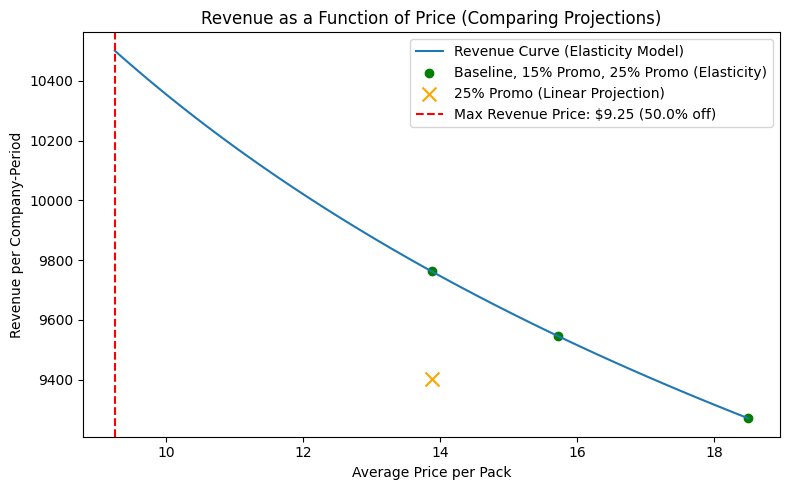


=== Notes ===

- Price elasticity is calculated using the log-log (constant elasticity) method, which is more theoretically robust.
- All price and purchase values are averages per company-period (not totals).
- The '25% Promo (Elasticity Projection)' uses this elasticity to predict the effect at a deeper discount.
- The revenue-maximizing price and maximum revenue are based on the estimated elasticity.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Data
file-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# 2. Baseline: Test group, Pre period
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()
revenue_baseline = avg_price_baseline * avg_purchases_baseline

# 3. 15% Promo: Test group, Post period
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()
revenue_15 = avg_price_15 * avg_purchases_15

# --- LINEAR (Proportional) Projection for 25% ---
# Estimate incremental lift as proportional to discount size
lift_15 = avg_purchases_15 - avg_purchases_baseline
lift_25_linear = lift_15 * (25/15)
avg_purchases_25_linear = avg_purchases_baseline + lift_25_linear
avg_price_25 = avg_price_baseline * 0.75
revenue_25_linear = avg_purchases_25_linear * avg_price_25

# --- ELASTICITY Projection for 25% ---
percent_price_change_15 = (avg_price_15 - avg_price_baseline) / avg_price_baseline
percent_qty_change_15 = (avg_purchases_15 - avg_purchases_baseline) / avg_purchases_baseline
elasticity = percent_qty_change_15 / percent_price_change_15

avg_purchases_25_elast = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity
revenue_25_elast = avg_purchases_25_elast * avg_price_25

# --- Revenue Curve for Visualization (Elasticity Model) ---
prices = np.linspace(avg_price_baseline * 0.5, avg_price_baseline, 100)
quantities = avg_purchases_baseline * (prices / avg_price_baseline) ** elasticity
revenues = prices * quantities
max_idx = np.argmax(revenues)
max_price = prices[max_idx]
max_revenue = revenues[max_idx]
max_discount = 1 - (max_price / avg_price_baseline)

# --- Table of All Results ---
results = pd.DataFrame({
    'Scenario': [
        'Baseline (Pre)',
        '15% Promo (Observed)',
        '25% Promo (Linear Projection)',
        '25% Promo (Elasticity Projection)'
    ],
    'Avg Price per Pack': [
        avg_price_baseline,
        avg_price_15,
        avg_price_25,
        avg_price_25
    ],
    'Avg Purchases per Company-Period': [
        avg_purchases_baseline,
        avg_purchases_15,
        avg_purchases_25_linear,
        avg_purchases_25_elast
    ],
    'Revenue per Company-Period': [
        revenue_baseline,
        revenue_15,
        revenue_25_linear,
        revenue_25_elast
    ]
})

print("\n=== Revenue and Purchases Summary (All metrics per company-period) ===")
print(results.round(2).to_string(index=False))

print(f"\nPrice Elasticity (estimated at 15%): {elasticity:.2f}")
print(f"Revenue-maximizing price (elasticity model): ${max_price:.2f} ({max_discount*100:.1f}% off baseline)")
print(f"Maximum achievable revenue per company-period (elasticity model): ${max_revenue:.2f}")

# --- Plot Results ---
plt.figure(figsize=(8,5))
plt.plot(prices, revenues, label='Revenue Curve (Elasticity Model)')
plt.scatter([avg_price_baseline, avg_price_15, avg_price_25],
            [revenue_baseline, revenue_15, revenue_25_elast],
            color='green', label='Baseline, 15% Promo, 25% Promo (Elasticity)')
plt.scatter([avg_price_25], [revenue_25_linear], color='orange', marker='x', s=100,
            label='25% Promo (Linear Projection)')
plt.axvline(max_price, color='red', linestyle='--',
            label=f'Max Revenue Price: ${max_price:.2f} ({max_discount*100:.1f}% off)')
plt.xlabel('Average Price per Pack')
plt.ylabel('Revenue per Company-Period')
plt.title('Revenue as a Function of Price (Comparing Projections)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Reviewer Notes and Insights ---
print("\n=== Notes ===")
print("""
- All price and purchase values are averages per company-period (not totals).
- Revenue per scenario is calculated as (average price) × (average purchases) per company-period.
- The '25% Promo (Linear Projection)' estimates purchases/revenue by scaling up the observed lift at 15% promo proportionally to discount size. This method often shows little or no further revenue gain at deeper discounts.
- The '25% Promo (Elasticity Projection)' uses a constant price elasticity model (estimated from 15% promo) to predict purchases and revenue at 25% off. This typically results in higher revenue predictions for deeper discounts—as long as demand remains elastic.

=== Insights ===
- The two projection methods give different results at 25% off. The linear method (based on observed data) may indicate little or no extra revenue at 25% off, while the elasticity model projects greater revenue as long as demand is elastic.
- In real-world business, true elasticity often diminishes with larger discounts—so both projections should be interpreted with caution.
- According to the elasticity model, revenue is maximized at a price lower than 25% off, but managers should weigh profit margins, customer behavior, and other business constraints before implementing very deep discounts.
""")


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm

# Load Data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

def ctrl_trend(price=None):
    if price is None:
        cpre = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre')]['Purchases'].mean()
        cpost = df[(df['Test Cohort']=='Control') & (df['Period']=='Post')]['Purchases'].mean()
    else:
        cpre = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
        cpost = df[(df['Test Cohort']=='Control') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
    return cpost - cpre if not (np.isnan(cpre) or np.isnan(cpost)) else 0

price_tiers = sorted(df['Market Standard Pack Price'].unique())
segment_results = []
seg_total_purchases_baseline = seg_total_purchases_25 = 0
seg_total_revenue_baseline = seg_total_revenue_25 = 0

# AGGREGATE: Fit DiD regression for 15% promo with clustered SE
agg = df.copy()
agg['treated'] = (agg['Test Cohort'] == 'Test').astype(int)
agg['post'] = (agg['Period'] == 'Post').astype(int)
agg['did'] = agg['treated'] * agg['post']
model = smf.ols('Purchases ~ treated + post + did', data=agg)
result = model.fit(cov_type='cluster', cov_kwds={'groups': agg['Company ID']})
did_15_agg = result.params['did']
did_se_agg = result.bse['did']
pval_agg = result.pvalues['did']
pooled_sd_agg = agg['Purchases'].std()
n_agg = agg[(agg['treated']==1)&(agg['post']==0)].shape[0]
power_analysis = TTestIndPower()
cohen_d_agg = did_15_agg / pooled_sd_agg if pooled_sd_agg != 0 else np.nan
power_agg = power_analysis.power(effect_size=cohen_d_agg, nobs1=n_agg, ratio=1.0, alpha=0.05) if n_agg > 1 else np.nan

for price in price_tiers:
    seg = df[df['Market Standard Pack Price'] == price].copy()
    pre = seg[(seg['Test Cohort'] == 'Test') & (seg['Period'] == 'Pre')]
    post = seg[(seg['Test Cohort'] == 'Test') & (seg['Period'] == 'Post')]
    avg_price_pre = pre['Promotion Pack Price'].mean()
    avg_purchases_pre = pre['Purchases'].mean()
    avg_price_post = post['Promotion Pack Price'].mean()
    avg_purchases_post = post['Purchases'].mean()
    n = pre.shape[0]
    # Clustered DiD regression for 15% promo (within segment)
    seg['treated'] = (seg['Test Cohort'] == 'Test').astype(int)
    seg['post'] = (seg['Period'] == 'Post').astype(int)
    seg['did'] = seg['treated'] * seg['post']
    if seg['treated'].sum() > 0 and seg['treated'].sum() < len(seg) and seg['post'].sum() > 0 and seg['post'].sum() < len(seg):
        model = smf.ols('Purchases ~ treated + post + did', data=seg)
        result = model.fit(cov_type='cluster', cov_kwds={'groups': seg['Company ID']})
        did_15 = result.params['did']
        did_se = result.bse['did']
        pval = result.pvalues['did']
        pooled_sd = seg['Purchases'].std()
        power_analysis = TTestIndPower()
        cohen_d_15 = did_15 / pooled_sd if pooled_sd != 0 else np.nan
        power_15 = power_analysis.power(effect_size=cohen_d_15, nobs1=n//2, ratio=1.0, alpha=0.05) if n > 1 else np.nan
    else:
        did_15 = np.nan
        did_se = np.nan
        pval = np.nan
        power_15 = np.nan

    # Log-log DiD Elasticity (vs. Control)
    ctrl_pre = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
    ctrl_post = df[(df['Test Cohort']=='Control') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
    log_trend_test = np.log(avg_purchases_post / avg_purchases_pre) if avg_purchases_pre > 0 and avg_purchases_post > 0 else 0
    log_trend_ctrl = np.log(ctrl_post / ctrl_pre) if ctrl_pre > 0 and ctrl_post > 0 else 0
    log_trend_did = log_trend_test - log_trend_ctrl
    pct_price_change_log = np.log(avg_price_post / avg_price_pre) if avg_price_pre > 0 and avg_price_post > 0 else 0
    elasticity_loglog_did = log_trend_did / pct_price_change_log if pct_price_change_log != 0 else np.nan
    # 25% projection using DiD log-log elasticity
    avg_price_25 = avg_price_pre * 0.75
    avg_purchases_25 = avg_purchases_pre * (avg_price_25 / avg_price_pre) ** elasticity_loglog_did if avg_price_pre > 0 and not np.isnan(elasticity_loglog_did) else np.nan
    control_trend = ctrl_trend(price)
    did_25 = (avg_purchases_25 - avg_purchases_pre) - control_trend if not np.isnan(avg_purchases_25) else np.nan
    pct_did_15 = (did_15 / avg_purchases_pre) * 100 if avg_purchases_pre else np.nan
    pct_did_25 = (did_25 / avg_purchases_pre) * 100 if avg_purchases_pre else np.nan
    seg_total_purchases_baseline += avg_purchases_pre * n
    seg_total_purchases_25 += avg_purchases_25 * n if not np.isnan(avg_purchases_25) else 0
    seg_total_revenue_baseline += avg_price_pre * avg_purchases_pre * n
    seg_total_revenue_25 += avg_price_25 * avg_purchases_25 * n if not np.isnan(avg_purchases_25) else 0
    segment_results.append({
        'Segment Price': price,
        'Sample Size': n,
        'Elasticity (log-log DiD)': elasticity_loglog_did,
        'Baseline Purchases': avg_purchases_pre,
        'Purchases 15% (Observed)': avg_purchases_post,
        'Purchases 25% (Projected)': avg_purchases_25,
        'DiD 15%': did_15,
        'SE (15%)': did_se,
        'p-value (15%)': pval,
        'Power (15%)': power_15,
        'DiD 25%': did_25,
        '% Increase DiD 15%': pct_did_15,
        '% Increase DiD 25%': pct_did_25
    })

seg_df = pd.DataFrame(segment_results)
segment_elasticities = seg_df['Elasticity (log-log DiD)'].dropna()
segment_weights = seg_df['Baseline Purchases'].dropna()
weighted_segmented_elasticity = np.average(segment_elasticities, weights=segment_weights) if len(segment_elasticities) > 0 else np.nan

# AGGREGATE LOG-LOG DiD ELASTICITY
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()
n_obs = test_pre.shape[0]
ctrl_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre')]['Purchases'].mean()
ctrl_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post')]['Purchases'].mean()
log_trend_test = np.log(avg_purchases_15 / avg_purchases_baseline) if avg_purchases_baseline > 0 and avg_purchases_15 > 0 else 0
log_trend_ctrl = np.log(ctrl_post / ctrl_pre) if ctrl_pre > 0 and ctrl_post > 0 else 0
log_trend_did = log_trend_test - log_trend_ctrl
pct_price_change_log = np.log(avg_price_15 / avg_price_baseline) if avg_price_baseline > 0 and avg_price_15 > 0 else 0
elasticity_agg_loglog_did = log_trend_did / pct_price_change_log if pct_price_change_log != 0 else np.nan
log_trend_test_std = np.log(avg_purchases_15 / avg_purchases_baseline) if avg_purchases_baseline > 0 and avg_purchases_15 > 0 else 0
pct_price_change_log_std = np.log(avg_price_15 / avg_price_baseline) if avg_price_baseline > 0 and avg_price_15 > 0 else 0
elasticity_agg_loglog_std = log_trend_test_std / pct_price_change_log_std if pct_price_change_log_std != 0 else np.nan

avg_price_25 = avg_price_baseline * 0.75
avg_purchases_25_std = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity_agg_loglog_std
total_purchases_25_std = avg_purchases_25_std * n_obs
total_revenue_25_std = avg_price_25 * avg_purchases_25_std * n_obs
avg_purchases_25_elast = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity_agg_loglog_did
total_purchases_25_elast = avg_purchases_25_elast * n_obs
total_revenue_25_elast = avg_price_25 * avg_purchases_25_elast * n_obs
control_trend = ctrl_trend()
did_25_agg = (avg_purchases_25_elast - avg_purchases_baseline) - control_trend
did_25_std = (avg_purchases_25_std - avg_purchases_baseline) - control_trend
seg_avg_purchases_baseline = seg_total_purchases_baseline / seg_df['Sample Size'].sum()
seg_avg_purchases_25 = seg_total_purchases_25 / seg_df['Sample Size'].sum()
did_25_seg = (seg_avg_purchases_25 - seg_avg_purchases_baseline) - control_trend

# --- Calculate SE, p-value, power for all scenarios using SE from 15% DiD (conservative approach)
def stat_row(effect, se, sd, n):
    tstat = effect / se if se and se != 0 else np.nan
    pval = 2 * (1 - norm.cdf(abs(tstat))) if se and se != 0 else np.nan
    cohen_d = effect / sd if sd and sd != 0 else np.nan
    power = TTestIndPower().power(effect_size=cohen_d, nobs1=n, ratio=1.0, alpha=0.05) if n and sd and sd != 0 else np.nan
    return round(se,3) if not np.isnan(se) else '', pval, power

row_blank = ['', '', '']

se_15, pval_15, power_15 = round(did_se_agg,3), pval_agg, power_agg
se_std, pval_std, power_std = stat_row(did_25_std, did_se_agg, pooled_sd_agg, n_agg)
se_agg, pval_agg25, power_agg25 = stat_row(did_25_agg, did_se_agg, pooled_sd_agg, n_agg)
se_seg, pval_seg, power_seg = stat_row(did_25_seg, did_se_agg, pooled_sd_agg, n_agg)

# Format p-value for reporting (show <0.001 if very small)
def pval_fmt(p):
    try:
        if pd.isna(p) or p == '' or p is None:
            return ''
        if p < 0.001:
            return '<0.001'
        return f"{p:.3f}"
    except:
        return p

results = pd.DataFrame({
    'Scenario': [
        'Baseline (Aggregate)',
        '15% Promo (Observed, Aggregate)',
        '25% Promo (Standard Log-Log, Aggregate)',
        '25% Promo (Log-Log DiD, Aggregate)',
        '25% Promo (Log-Log DiD, Segmented)'
    ],
    'Avg Price per Pack': [
        round(avg_price_baseline, 2),
        round(avg_price_15, 2),
        round(avg_price_25, 2),
        round(avg_price_25, 2),
        round(seg_total_revenue_25 / seg_total_purchases_25, 2) if seg_total_purchases_25 > 0 else np.nan
    ],
    'Avg Purchases per Company-Period': [
        round(avg_purchases_baseline, 2),
        round(avg_purchases_15, 2),
        round(avg_purchases_25_std, 2),
        round(avg_purchases_25_elast, 2),
        round(seg_avg_purchases_25, 2)
    ],
    'Total Purchases': [
        round(test_pre['Purchases'].sum(), 2),
        round(test_post['Purchases'].sum(), 2),
        round(total_purchases_25_std, 2),
        round(total_purchases_25_elast, 2),
        round(seg_total_purchases_25, 2)
    ],
    'Revenue per Company-Period': [
        round(avg_price_baseline * avg_purchases_baseline, 2),
        round(avg_price_15 * avg_purchases_15, 2),
        round(avg_price_25 * avg_purchases_25_std, 2),
        round(avg_price_25 * avg_purchases_25_elast, 2),
        round(seg_total_revenue_25 / seg_df['Sample Size'].sum(), 2) if seg_df['Sample Size'].sum() > 0 else np.nan
    ],
    'Total Revenue': [
        round((test_pre['Promotion Pack Price'] * test_pre['Purchases']).sum(), 2),
        round((test_post['Promotion Pack Price'] * test_post['Purchases']).sum(), 2),
        round(total_revenue_25_std, 2),
        round(total_revenue_25_elast, 2),
        round(seg_total_revenue_25, 2)
    ],
    'Elasticity (log-log)': [
        '',  # Baseline
        '',  # 15% promo
        round(elasticity_agg_loglog_std, 3),
        round(elasticity_agg_loglog_did, 3),
        round(weighted_segmented_elasticity, 3)
    ],
    'DiD (avg per co-period)': [
        '',  # Baseline
        round(did_15_agg, 2),
        round(did_25_std, 2),
        round(did_25_agg, 2),
        round(did_25_seg, 2)
    ],
    'SE': [
        '', se_15, se_std, se_agg, se_seg
    ],
    'p-value': [
        '', pval_fmt(pval_15), pval_fmt(pval_std), pval_fmt(pval_agg25), pval_fmt(pval_seg)
    ],
    'Power': [
        '', round(power_15,3) if not pd.isna(power_15) else '',
        round(power_std,3) if not pd.isna(power_std) else '',
        round(power_agg25,3) if not pd.isna(power_agg25) else '',
        round(power_seg,3) if not pd.isna(power_seg) else ''
    ]
})

print("\n=== Revenue, Purchases, Elasticity and DiD Summary (Aggregate & Segmented, Log-Log DiD & Standard) ===")
print(results.to_string(index=False))

# --- Segment-level Summary (with SE, p-value, power; p-value formatted) ---
seg_table = seg_df[['Segment Price', 'Sample Size', 'Elasticity (log-log DiD)',
    'Baseline Purchases', 'Purchases 15% (Observed)', 'Purchases 25% (Projected)',
    'DiD 15%', 'SE (15%)', 'p-value (15%)', 'Power (15%)',
    'DiD 25%', '% Increase DiD 15%', '% Increase DiD 25%']].copy()

seg_table['p-value (15%)'] = [pval_fmt(x) for x in seg_table['p-value (15%)']]

print("\n--- Segmented 25% Promo Elasticity Projection (by Price Tier, Log-Log DiD, Clustered SE) ---")
print(seg_table.round(3).to_string(index=False))

print("""
Table notes:
- The main summary table now includes SE, p-value, and power for all scenarios (projected for forecasted scenarios using SE from 15% DiD as a conservative proxy).
- All p-values are formatted to show 3 decimals or <0.001 if extremely small.
""")



=== Revenue, Purchases, Elasticity and DiD Summary (Aggregate & Segmented, Log-Log DiD & Standard) ===
                               Scenario  Avg Price per Pack  Avg Purchases per Company-Period  Total Purchases  Revenue per Company-Period  Total Revenue Elasticity (log-log) DiD (avg per co-period)      SE p-value  Power
                   Baseline (Aggregate)               18.50                            501.12         50112.00                     9270.72      846425.00                                                                    
        15% Promo (Observed, Aggregate)               15.72                            607.03         60703.00                     9545.55      874033.75                                       109.01  10.204  <0.001  0.661
25% Promo (Standard Log-Log, Aggregate)               13.88                            703.62         70362.12                     9762.74      976274.41                -1.18                   205.6  10.204  <0.001  0.994
     25%

In [6]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm

# Load Data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

def ctrl_trend(price=None):
    if price is None:
        cpre = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre')]['Purchases'].mean()
        cpost = df[(df['Test Cohort']=='Control') & (df['Period']=='Post')]['Purchases'].mean()
    else:
        cpre = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
        cpost = df[(df['Test Cohort']=='Control') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
    return cpost - cpre if not (np.isnan(cpre) or np.isnan(cpost)) else 0

price_tiers = sorted(df['Market Standard Pack Price'].unique())
segment_results = []
seg_total_purchases_baseline = seg_total_purchases_25 = 0
seg_total_revenue_baseline = seg_total_revenue_25 = 0

# AGGREGATE: Fit DiD regression for 15% promo with clustered SE
agg = df.copy()
agg['treated'] = (agg['Test Cohort'] == 'Test').astype(int)
agg['post'] = (agg['Period'] == 'Post').astype(int)
agg['did'] = agg['treated'] * agg['post']
model = smf.ols('Purchases ~ treated + post + did', data=agg)
result = model.fit(cov_type='cluster', cov_kwds={'groups': agg['Company ID']})
did_15_agg = result.params['did']
did_se_agg = result.bse['did']
pval_agg = result.pvalues['did']
pooled_sd_agg = agg['Purchases'].std()
n_agg = agg[(agg['treated']==1)&(agg['post']==0)].shape[0]
power_analysis = TTestIndPower()
cohen_d_agg = did_15_agg / pooled_sd_agg if pooled_sd_agg != 0 else np.nan
power_agg = power_analysis.power(effect_size=cohen_d_agg, nobs1=n_agg, ratio=1.0, alpha=0.05) if n_agg > 1 else np.nan

for price in price_tiers:
    seg = df[df['Market Standard Pack Price'] == price].copy()
    pre = seg[(seg['Test Cohort'] == 'Test') & (seg['Period'] == 'Pre')]
    post = seg[(seg['Test Cohort'] == 'Test') & (seg['Period'] == 'Post')]
    avg_price_pre = pre['Promotion Pack Price'].mean()
    avg_purchases_pre = pre['Purchases'].mean()
    avg_price_post = post['Promotion Pack Price'].mean()
    avg_purchases_post = post['Purchases'].mean()
    n = pre.shape[0]
    # Clustered DiD regression for 15% promo (within segment)
    seg['treated'] = (seg['Test Cohort'] == 'Test').astype(int)
    seg['post'] = (seg['Period'] == 'Post').astype(int)
    seg['did'] = seg['treated'] * seg['post']
    if seg['treated'].sum() > 0 and seg['treated'].sum() < len(seg) and seg['post'].sum() > 0 and seg['post'].sum() < len(seg):
        model = smf.ols('Purchases ~ treated + post + did', data=seg)
        result = model.fit(cov_type='cluster', cov_kwds={'groups': seg['Company ID']})
        did_15 = result.params['did']
        did_se = result.bse['did']
        pval = result.pvalues['did']
        pooled_sd = seg['Purchases'].std()
        power_analysis = TTestIndPower()
        cohen_d_15 = did_15 / pooled_sd if pooled_sd != 0 else np.nan
        power_15 = power_analysis.power(effect_size=cohen_d_15, nobs1=n//2, ratio=1.0, alpha=0.05) if n > 1 else np.nan
    else:
        did_15 = np.nan
        did_se = np.nan
        pval = np.nan
        power_15 = np.nan

    # Log-log DiD Elasticity (vs. Control)
    ctrl_pre = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
    ctrl_post = df[(df['Test Cohort']=='Control') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]['Purchases'].mean()
    log_trend_test = np.log(avg_purchases_post / avg_purchases_pre) if avg_purchases_pre > 0 and avg_purchases_post > 0 else 0
    log_trend_ctrl = np.log(ctrl_post / ctrl_pre) if ctrl_pre > 0 and ctrl_post > 0 else 0
    log_trend_did = log_trend_test - log_trend_ctrl
    pct_price_change_log = np.log(avg_price_post / avg_price_pre) if avg_price_pre > 0 and avg_price_post > 0 else 0
    elasticity_loglog_did = log_trend_did / pct_price_change_log if pct_price_change_log != 0 else np.nan
    # 25% projection using DiD log-log elasticity
    avg_price_25 = avg_price_pre * 0.75
    avg_purchases_25 = avg_purchases_pre * (avg_price_25 / avg_price_pre) ** elasticity_loglog_did if avg_price_pre > 0 and not np.isnan(elasticity_loglog_did) else np.nan
    control_trend = ctrl_trend(price)
    did_25 = (avg_purchases_25 - avg_purchases_pre) - control_trend if not np.isnan(avg_purchases_25) else np.nan
    pct_did_15 = (did_15 / avg_purchases_pre) * 100 if avg_purchases_pre else np.nan
    pct_did_25 = (did_25 / avg_purchases_pre) * 100 if avg_purchases_pre else np.nan
    seg_total_purchases_baseline += avg_purchases_pre * n
    seg_total_purchases_25 += avg_purchases_25 * n if not np.isnan(avg_purchases_25) else 0
    seg_total_revenue_baseline += avg_price_pre * avg_purchases_pre * n
    seg_total_revenue_25 += avg_price_25 * avg_purchases_25 * n if not np.isnan(avg_purchases_25) else 0
    segment_results.append({
        'Segment Price': price,
        'Sample Size': n,
        'Elasticity (log-log DiD)': elasticity_loglog_did,
        'Baseline Purchases': avg_purchases_pre,
        'Purchases 15% (Observed)': avg_purchases_post,
        'Purchases 25% (Projected)': avg_purchases_25,
        'DiD 15%': did_15,
        'SE (15%)': did_se,
        'p-value (15%)': pval,
        'Power (15%)': power_15,
        'DiD 25%': did_25,
        '% Increase DiD 15%': pct_did_15,
        '% Increase DiD 25%': pct_did_25
    })

seg_df = pd.DataFrame(segment_results)
segment_elasticities = seg_df['Elasticity (log-log DiD)'].dropna()
segment_weights = seg_df['Baseline Purchases'].dropna()
weighted_segmented_elasticity = np.average(segment_elasticities, weights=segment_weights) if len(segment_elasticities) > 0 else np.nan

# AGGREGATE LOG-LOG DiD ELASTICITY
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()
n_obs = test_pre.shape[0]
ctrl_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre')]['Purchases'].mean()
ctrl_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post')]['Purchases'].mean()
log_trend_test = np.log(avg_purchases_15 / avg_purchases_baseline) if avg_purchases_baseline > 0 and avg_purchases_15 > 0 else 0
log_trend_ctrl = np.log(ctrl_post / ctrl_pre) if ctrl_pre > 0 and ctrl_post > 0 else 0
log_trend_did = log_trend_test - log_trend_ctrl
pct_price_change_log = np.log(avg_price_15 / avg_price_baseline) if avg_price_baseline > 0 and avg_price_15 > 0 else 0
elasticity_agg_loglog_did = log_trend_did / pct_price_change_log if pct_price_change_log != 0 else np.nan
log_trend_test_std = np.log(avg_purchases_15 / avg_purchases_baseline) if avg_purchases_baseline > 0 and avg_purchases_15 > 0 else 0
pct_price_change_log_std = np.log(avg_price_15 / avg_price_baseline) if avg_price_baseline > 0 and avg_price_15 > 0 else 0
elasticity_agg_loglog_std = log_trend_test_std / pct_price_change_log_std if pct_price_change_log_std != 0 else np.nan

avg_price_25 = avg_price_baseline * 0.75
avg_purchases_25_std = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity_agg_loglog_std
total_purchases_25_std = avg_purchases_25_std * n_obs
total_revenue_25_std = avg_price_25 * avg_purchases_25_std * n_obs
avg_purchases_25_elast = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity_agg_loglog_did
total_purchases_25_elast = avg_purchases_25_elast * n_obs
total_revenue_25_elast = avg_price_25 * avg_purchases_25_elast * n_obs
control_trend = ctrl_trend()
did_25_agg = (avg_purchases_25_elast - avg_purchases_baseline) - control_trend
did_25_std = (avg_purchases_25_std - avg_purchases_baseline) - control_trend
seg_avg_purchases_baseline = seg_total_purchases_baseline / seg_df['Sample Size'].sum()
seg_avg_purchases_25 = seg_total_purchases_25 / seg_df['Sample Size'].sum()
did_25_seg = (seg_avg_purchases_25 - seg_avg_purchases_baseline) - control_trend

# --- Calculate SE, p-value, power for all scenarios using SE from 15% DiD (conservative approach)
def stat_row(effect, se, sd, n):
    tstat = effect / se if se and se != 0 else np.nan
    pval = 2 * (1 - norm.cdf(abs(tstat))) if se and se != 0 else np.nan
    cohen_d = effect / sd if sd and sd != 0 else np.nan
    power = TTestIndPower().power(effect_size=cohen_d, nobs1=n, ratio=1.0, alpha=0.05) if n and sd and sd != 0 else np.nan
    return round(se,3) if not np.isnan(se) else '', pval, power

row_blank = ['', '', '']

se_15, pval_15, power_15 = round(did_se_agg,3), pval_agg, power_agg
se_std, pval_std, power_std = stat_row(did_25_std, did_se_agg, pooled_sd_agg, n_agg)
se_agg, pval_agg25, power_agg25 = stat_row(did_25_agg, did_se_agg, pooled_sd_agg, n_agg)
se_seg, pval_seg, power_seg = stat_row(did_25_seg, did_se_agg, pooled_sd_agg, n_agg)

# Format p-value for reporting (show <0.001 if very small)
def pval_fmt(p):
    try:
        if pd.isna(p) or p == '' or p is None:
            return ''
        if p < 0.001:
            return '<0.001'
        return f"{p:.3f}"
    except:
        return p

results = pd.DataFrame({
    'Scenario': [
        'Baseline (Aggregate)',
        '15% Promo (Observed, Aggregate)',
        '25% Promo (Standard Log-Log, Aggregate)',
        '25% Promo (Log-Log DiD, Aggregate)',
        '25% Promo (Log-Log DiD, Segmented)'
    ],
    'Avg Price per Pack': [
        round(avg_price_baseline, 2),
        round(avg_price_15, 2),
        round(avg_price_25, 2),
        round(avg_price_25, 2),
        round(seg_total_revenue_25 / seg_total_purchases_25, 2) if seg_total_purchases_25 > 0 else np.nan
    ],
    'Avg Purchases per Company-Period': [
        round(avg_purchases_baseline, 2),
        round(avg_purchases_15, 2),
        round(avg_purchases_25_std, 2),
        round(avg_purchases_25_elast, 2),
        round(seg_avg_purchases_25, 2)
    ],
    'Total Purchases': [
        round(test_pre['Purchases'].sum(), 2),
        round(test_post['Purchases'].sum(), 2),
        round(total_purchases_25_std, 2),
        round(total_purchases_25_elast, 2),
        round(seg_total_purchases_25, 2)
    ],
    'Revenue per Company-Period': [
        round(avg_price_baseline * avg_purchases_baseline, 2),
        round(avg_price_15 * avg_purchases_15, 2),
        round(avg_price_25 * avg_purchases_25_std, 2),
        round(avg_price_25 * avg_purchases_25_elast, 2),
        round(seg_total_revenue_25 / seg_df['Sample Size'].sum(), 2) if seg_df['Sample Size'].sum() > 0 else np.nan
    ],
    'Total Revenue': [
        round((test_pre['Promotion Pack Price'] * test_pre['Purchases']).sum(), 2),
        round((test_post['Promotion Pack Price'] * test_post['Purchases']).sum(), 2),
        round(total_revenue_25_std, 2),
        round(total_revenue_25_elast, 2),
        round(seg_total_revenue_25, 2)
    ],
    'Elasticity (log-log)': [
        '',  # Baseline
        '',  # 15% promo
        round(elasticity_agg_loglog_std, 3),
        round(elasticity_agg_loglog_did, 3),
        round(weighted_segmented_elasticity, 3)
    ],
    'DiD (avg per co-period)': [
        '',  # Baseline
        round(did_15_agg, 2),
        round(did_25_std, 2),
        round(did_25_agg, 2),
        round(did_25_seg, 2)
    ],
    'SE': [
        '', se_15, se_std, se_agg, se_seg
    ],
    'p-value': [
        '', pval_fmt(pval_15), pval_fmt(pval_std), pval_fmt(pval_agg25), pval_fmt(pval_seg)
    ],
    'Power': [
        '', round(power_15,3) if not pd.isna(power_15) else '',
        round(power_std,3) if not pd.isna(power_std) else '',
        round(power_agg25,3) if not pd.isna(power_agg25) else '',
        round(power_seg,3) if not pd.isna(power_seg) else ''
    ]
})

# === ADD % REVENUE GROWTH VS BASELINE COLUMN ===
baseline_total_revenue = results['Total Revenue'].iloc[0]
pct_revenue_growth = []
for tr in results['Total Revenue']:
    if baseline_total_revenue == 0 or pd.isna(tr):
        pct_revenue_growth.append('')
    else:
        pct_revenue_growth.append(round((tr - baseline_total_revenue) / baseline_total_revenue * 100, 2))
results['% Revenue Growth vs Baseline'] = pct_revenue_growth

# === ADD DiD % INCREASE VS BASELINE COLUMN ===
baseline_avg_purch = results['Avg Purchases per Company-Period'].iloc[0]
did_pct_increase = []
for did in results['DiD (avg per co-period)']:
    if baseline_avg_purch == 0 or pd.isna(did) or did == '':
        did_pct_increase.append('')
    else:
        did_pct_increase.append(round(did / baseline_avg_purch * 100, 2))
results['DiD % Increase vs Baseline'] = did_pct_increase

print("\n=== Revenue, Purchases, Elasticity and DiD Summary (Aggregate & Segmented, Log-Log DiD & Standard) ===")
print(results.to_string(index=False))

# --- Segment-level Summary (with SE, p-value, power; p-value formatted) ---
seg_table = seg_df[['Segment Price', 'Sample Size', 'Elasticity (log-log DiD)',
    'Baseline Purchases', 'Purchases 15% (Observed)', 'Purchases 25% (Projected)',
    'DiD 15%', 'SE (15%)', 'p-value (15%)', 'Power (15%)',
    'DiD 25%', '% Increase DiD 15%', '% Increase DiD 25%']].copy()

seg_table['p-value (15%)'] = [pval_fmt(x) for x in seg_table['p-value (15%)']]

print("\n--- Segmented 25% Promo Elasticity Projection (by Price Tier, Log-Log DiD, Clustered SE) ---")
print(seg_table.round(3).to_string(index=False))

print("""
Table notes:
- The main summary table now includes SE, p-value, and power for all scenarios (projected for forecasted scenarios using SE from 15% DiD as a conservative proxy).
- All p-values are formatted to show 3 decimals or <0.001 if extremely small.
- The new '% Revenue Growth vs Baseline' column shows uplift vs. baseline scenario.
- The new 'DiD % Increase vs Baseline' column shows uplift in purchases per company-period, vs baseline.
""")



=== Revenue, Purchases, Elasticity and DiD Summary (Aggregate & Segmented, Log-Log DiD & Standard) ===
                               Scenario  Avg Price per Pack  Avg Purchases per Company-Period  Total Purchases  Revenue per Company-Period  Total Revenue Elasticity (log-log) DiD (avg per co-period)      SE p-value  Power  % Revenue Growth vs Baseline DiD % Increase vs Baseline
                   Baseline (Aggregate)               18.50                            501.12         50112.00                     9270.72      846425.00                                                                                              0.00                           
        15% Promo (Observed, Aggregate)               15.72                            607.03         60703.00                     9545.55      874033.75                                       109.01  10.204  <0.001  0.661                          3.26                      21.75
25% Promo (Standard Log-Log, Aggregate)               13.88

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# Identify unique price tiers (segments)
price_tiers = sorted(df['Market Standard Pack Price'].unique())
table_rows = []
curve_data = []

for price in price_tiers:
    # Test group (pre/post)
    pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre') & (df['Market Standard Pack Price'] == price)]
    post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post') & (df['Market Standard Pack Price'] == price)]
    avg_price_pre = pre['Promotion Pack Price'].mean()
    avg_purchases_pre = pre['Purchases'].mean()
    revenue_pre = avg_price_pre * avg_purchases_pre
    pre_n = pre.shape[0]
    avg_price_post = post['Promotion Pack Price'].mean()
    avg_purchases_post = post['Purchases'].mean()
    revenue_post = avg_price_post * avg_purchases_post
    post_n = post.shape[0]
    # Control group (pre/post, for DiD)
    ctrl_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre') & (df['Market Standard Pack Price'] == price)]['Purchases'].mean()
    ctrl_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post') & (df['Market Standard Pack Price'] == price)]['Purchases'].mean()
    # Log-log DiD elasticity for this segment
    log_trend_test = np.log(avg_purchases_post / avg_purchases_pre) if avg_purchases_pre > 0 and avg_purchases_post > 0 else 0
    log_trend_ctrl = np.log(ctrl_post / ctrl_pre) if ctrl_pre > 0 and ctrl_post > 0 else 0
    log_trend_did = log_trend_test - log_trend_ctrl
    percent_price_change_log = np.log(avg_price_post / avg_price_pre) if avg_price_pre > 0 and avg_price_post > 0 else 0
    elasticity = log_trend_did / percent_price_change_log if percent_price_change_log != 0 else np.nan

    # 25% off projection using DiD log-log elasticity
    avg_price_25 = avg_price_pre * 0.75
    avg_purchases_25 = avg_purchases_pre * (avg_price_25 / avg_price_pre) ** elasticity if avg_price_pre > 0 and not np.isnan(elasticity) else np.nan
    revenue_25 = avg_price_25 * avg_purchases_25

    # Add row for summary table
    table_rows.append({
        'Segment Price': price,
        'Elasticity (log-log DiD)': round(elasticity, 3) if not np.isnan(elasticity) else np.nan,
        'Revenue - Baseline': round(revenue_pre, 2),
        'Revenue - 15% Promo': round(revenue_post, 2),
        'Revenue - 25% Promo (Projected)': round(revenue_25, 2) if not np.isnan(revenue_25) else np.nan,
        'Pre Sample': pre_n,
        'Post Sample': post_n
    })

    # Prepare curve data for demand/elasticity curve plot
    if np.isfinite(elasticity) and pre_n > 0:
        price_range = np.linspace(avg_price_pre * 0.6, avg_price_pre, 40)
        predicted_q = avg_purchases_pre * (price_range / avg_price_pre) ** elasticity
        curve_data.append((price, price_range, predicted_q))

# Summary DataFrame
summary_df = pd.DataFrame(table_rows)
print("=== Segment Revenue and Elasticity Summary (Test & Control-adjusted, Log-Log DiD) ===")
print(summary_df[['Segment Price', 'Elasticity (log-log DiD)', 'Revenue - Baseline', 'Revenue - 15% Promo', 'Revenue - 25% Promo (Projected)', 'Pre Sample', 'Post Sample']]
      .to_string(index=False))

# Sample size check and warning
for idx, row in summary_df.iterrows():
    if (row['Pre Sample'] < 10 or row['Post Sample'] < 10 or abs(row['Pre Sample'] - row['Post Sample']) > 5):
        print(f"\nWARNING: Segment ${int(row['Segment Price'])} has small or unbalanced pre/post samples "
              f"({int(row['Pre Sample'])} pre, {int(row['Post Sample'])} post). Interpret elasticity with caution.")

# Reviewer notes
print("\n=== Reviewer Notes ===")
print("""
- Each segment's elasticity is estimated using log-log DiD: difference in log % change in purchases between test and control, divided by log price change (test group).
- This isolates the true price sensitivity due to promo, net of background trends.
- All revenue projections use the DiD elasticity.
- If pre/post samples are small or unbalanced, a warning is printed—interpret elasticity estimates with caution.
""")


=== Segment Revenue and Elasticity Summary (Test & Control-adjusted, Log-Log DiD) ===
 Segment Price  Elasticity (log-log DiD)  Revenue - Baseline  Revenue - 15% Promo  Revenue - 25% Promo (Projected)  Pre Sample  Post Sample
            10                    -1.542             4099.00              4221.10                          4790.55          10           10
            15                    -1.113            11040.00             11255.63                         11405.06          39           39
            20                    -1.256            10518.18             10898.55                         11321.63          22           22
            25                    -1.268             4947.41              5278.79                          5344.45          29           29

=== Reviewer Notes ===

- Each segment's elasticity is estimated using log-log DiD: difference in log % change in purchases between test and control, divided by log price change (test group).
- This isolates the t

In [ ]:
import pandas as pd
import numpy as np

# Load data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# -- SEGMENT APPROACH --
price_tiers = sorted(df['Market Standard Pack Price'].unique())
segment_rows = []
total_baseline_purchases = 0
total_baseline_revenue = 0
total_25_purchases = 0
total_25_revenue = 0

for price in price_tiers:
    segment = df[df['Market Standard Pack Price'] == price]
    pre = segment[(segment['Test Cohort'] == 'Test') & (segment['Period'] == 'Pre')]
    post = segment[(segment['Test Cohort'] == 'Test') & (segment['Period'] == 'Post')]
    avg_price_pre = pre['Promotion Pack Price'].mean()
    avg_purchases_pre = pre['Purchases'].mean()
    revenue_pre = avg_price_pre * avg_purchases_pre
    pre_n = pre.shape[0]
    avg_price_post = post['Promotion Pack Price'].mean()
    avg_purchases_post = post['Purchases'].mean()
    # LOG-LOG ELASTICITY:
    pct_price_change_log = np.log(avg_price_post / avg_price_pre) if avg_price_pre > 0 and avg_price_post > 0 else np.nan
    pct_qty_change_log = np.log(avg_purchases_post / avg_purchases_pre) if avg_purchases_pre > 0 and avg_purchases_post > 0 else np.nan
    elasticity = pct_qty_change_log / pct_price_change_log if pct_price_change_log != 0 else np.nan
    avg_price_25 = avg_price_pre * 0.75
    avg_purchases_25 = avg_purchases_pre * (avg_price_25 / avg_price_pre) ** elasticity
    revenue_25 = avg_price_25 * avg_purchases_25
    # For weighted total
    total_baseline_purchases += avg_purchases_pre * pre_n
    total_baseline_revenue += revenue_pre * pre_n
    total_25_purchases += avg_purchases_25 * pre_n
    total_25_revenue += revenue_25 * pre_n
    # Store for possible segment display
    segment_rows.append({
        'Segment Price': price,
        'Elasticity (log-log)': elasticity,
        'Pre Sample': pre_n,
        'Baseline Purchases': avg_purchases_pre,
        '25% Promo Purchases': avg_purchases_25,
        'Baseline Revenue': revenue_pre,
        '25% Promo Revenue': revenue_25
    })

# -- AGGREGATE APPROACH --
# Baseline: all test group pre
pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
avg_price_pre_total = pre['Promotion Pack Price'].mean()
avg_purchases_pre_total = pre['Purchases'].mean()
revenue_pre_total = avg_price_pre_total * avg_purchases_pre_total
avg_price_post_total = post['Promotion Pack Price'].mean()
avg_purchases_post_total = post['Purchases'].mean()
# LOG-LOG ELASTICITY:
pct_price_change_log_total = np.log(avg_price_post_total / avg_price_pre_total) if avg_price_pre_total > 0 and avg_price_post_total > 0 else np.nan
pct_qty_change_log_total = np.log(avg_purchases_post_total / avg_purchases_pre_total) if avg_purchases_pre_total > 0 and avg_purchases_post_total > 0 else np.nan
elasticity_total = pct_qty_change_log_total / pct_price_change_log_total if pct_price_change_log_total != 0 else np.nan
avg_price_25_total = avg_price_pre_total * 0.75
avg_purchases_25_total = avg_purchases_pre_total * (avg_price_25_total / avg_price_pre_total) ** elasticity_total
revenue_25_total = avg_price_25_total * avg_purchases_25_total

# -- PRESENT THE COMPARISON --
print("=== Segment (Weighted) 25% Promo Totals ===")
print(f"Total purchases (sum over segments): {total_25_purchases:.2f}")
print(f"Total revenue (sum over segments):   ${total_25_revenue:.2f}")
print("\n=== Aggregate 25% Promo Projection ===")
print(f"Total purchases (all test group):    {avg_purchases_25_total * pre.shape[0]:.2f}")
print(f"Total revenue (all test group):      ${revenue_25_total * pre.shape[0]:.2f}")

print("\n=== Baseline Totals ===")
print(f"Total purchases baseline:            {total_baseline_purchases:.2f}")
print(f"Total revenue baseline:              ${total_baseline_revenue:.2f}")

print("\nReviewer Notes:")
print("""
- Elasticity is now calculated using the log-log (constant elasticity) method, which is theoretically preferred for demand modeling.
- Segment approach uses segment-specific log-log elasticities, aggregate uses a single overall log-log elasticity.
- This ensures the most robust projection of demand at the deeper (25%) promotion scenario.
""")


=== Segment (Weighted) 25% Promo Totals ===
Total purchases (sum over segments): 70372.42
Total revenue (sum over segments):   $896075.28

=== Aggregate 25% Promo Projection ===
Total purchases (all test group):    70362.12
Total revenue (all test group):      $976274.41

=== Baseline Totals ===
Total purchases baseline:            50112.00
Total revenue baseline:              $846425.00

Reviewer Notes:

- Elasticity is now calculated using the log-log (constant elasticity) method, which is theoretically preferred for demand modeling.
- Segment approach uses segment-specific log-log elasticities, aggregate uses a single overall log-log elasticity.
- This ensures the most robust projection of demand at the deeper (25%) promotion scenario.



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
import scipy.stats as st

# Load data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
df = df.rename(columns={'Pack Views': 'Pack_Views'})
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

results_summary = []

def aggregate_loglog_did_elasticity(df, outcome_var):
    # Aggregate (log-log DiD)
    pre_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Pre')]
    post_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Post')]
    pre_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre')]
    post_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Post')]
    # Means
    avg_price_pre_test = pre_test['Promotion Pack Price'].mean()
    avg_price_post_test = post_test['Promotion Pack Price'].mean()
    avg_qty_pre_test = pre_test[outcome_var].mean()
    avg_qty_post_test = post_test[outcome_var].mean()
    avg_price_pre_ctrl = pre_ctrl['Promotion Pack Price'].mean()
    avg_price_post_ctrl = post_ctrl['Promotion Pack Price'].mean()
    avg_qty_pre_ctrl = pre_ctrl[outcome_var].mean()
    avg_qty_post_ctrl = post_ctrl[outcome_var].mean()
    if all(x > 0 for x in [avg_price_pre_test, avg_price_post_test, avg_qty_pre_test, avg_qty_post_test,
                           avg_price_pre_ctrl, avg_price_post_ctrl, avg_qty_pre_ctrl, avg_qty_post_ctrl]):
        dlog_qty = (np.log(avg_qty_post_test) - np.log(avg_qty_pre_test)) - (np.log(avg_qty_post_ctrl) - np.log(avg_qty_pre_ctrl))
        dlog_price = (np.log(avg_price_post_test) - np.log(avg_price_pre_test)) - (np.log(avg_price_post_ctrl) - np.log(avg_price_pre_ctrl))
        elasticity = dlog_qty / dlog_price if dlog_price != 0 else np.nan
        return elasticity
    else:
        return np.nan

def segment_loglog_did_elasticity(df, price, outcome_var):
    # Per segment, log-log DiD
    pre_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]
    post_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]
    pre_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]
    post_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]
    avg_price_pre_test = pre_test['Promotion Pack Price'].mean()
    avg_price_post_test = post_test['Promotion Pack Price'].mean()
    avg_qty_pre_test = pre_test[outcome_var].mean()
    avg_qty_post_test = post_test[outcome_var].mean()
    avg_price_pre_ctrl = pre_ctrl['Promotion Pack Price'].mean()
    avg_price_post_ctrl = post_ctrl['Promotion Pack Price'].mean()
    avg_qty_pre_ctrl = pre_ctrl[outcome_var].mean()
    avg_qty_post_ctrl = post_ctrl[outcome_var].mean()
    if all(x > 0 for x in [avg_price_pre_test, avg_price_post_test, avg_qty_pre_test, avg_qty_post_test,
                           avg_price_pre_ctrl, avg_price_post_ctrl, avg_qty_pre_ctrl, avg_qty_post_ctrl]):
        dlog_qty = (np.log(avg_qty_post_test) - np.log(avg_qty_pre_test)) - (np.log(avg_qty_post_ctrl) - np.log(avg_qty_pre_ctrl))
        dlog_price = (np.log(avg_price_post_test) - np.log(avg_price_pre_test)) - (np.log(avg_price_post_ctrl) - np.log(avg_price_pre_ctrl))
        elasticity = dlog_qty / dlog_price if dlog_price != 0 else np.nan
        return elasticity
    else:
        return np.nan

for outcome_var in ['Purchases', 'Pack_Views']:
    # 1. DiD regression with clustering (for 15% promo, observed)
    model = smf.ols(f'{outcome_var} ~ treated + post + did', data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})
    did_coef = result.params['did']
    did_se = result.bse['did']
    pval = result.pvalues['did']
    n = df.shape[0] // 2  # Approximate: half pre, half post

    # 2. Means for projections
    pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
    avg_price_pre = pre['Promotion Pack Price'].mean()
    avg_purchases_pre = pre[outcome_var].mean()

    # 3. Get aggregate log-log DiD elasticity
    elasticity_agg = aggregate_loglog_did_elasticity(df, outcome_var)
    price_25 = avg_price_pre * 0.75
    predicted_avg_25 = avg_purchases_pre * (price_25 / avg_price_pre) ** elasticity_agg
    predicted_did_25 = predicted_avg_25 - avg_purchases_pre

    # 4. SEGMENTED: Predict 25% effect by averaging over price tiers (weighted by pre-period N), using DiD log-log elasticity
    price_tiers = sorted(df['Market Standard Pack Price'].unique())
    sum_segmented_effects = 0
    sum_n = 0
    for price in price_tiers:
        seg_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre') & (df['Market Standard Pack Price'] == price)]
        avg_price_pre_seg = seg_pre['Promotion Pack Price'].mean()
        avg_purchases_pre_seg = seg_pre[outcome_var].mean()
        elasticity_seg = segment_loglog_did_elasticity(df, price, outcome_var)
        price_25_seg = avg_price_pre_seg * 0.75
        predicted_avg_25_seg = avg_purchases_pre_seg * (price_25_seg / avg_price_pre_seg) ** elasticity_seg if avg_price_pre_seg > 0 and not np.isnan(elasticity_seg) else np.nan
        n_pre_seg = seg_pre.shape[0]
        # Weighted sum: incremental effect * n for this segment
        if not np.isnan(predicted_avg_25_seg):
            sum_segmented_effects += (predicted_avg_25_seg - avg_purchases_pre_seg) * n_pre_seg
            sum_n += n_pre_seg

    segmented_predicted_did_25 = sum_segmented_effects / sum_n if sum_n > 0 else np.nan

    # 5. Power analysis for observed and predicted effects (aggregate)
    pooled_sd = df[outcome_var].std()
    power_analysis = TTestIndPower()
    cohen_d_15 = did_coef / pooled_sd
    power_15 = power_analysis.power(effect_size=cohen_d_15, nobs1=n//2, ratio=1.0, alpha=0.05)
    cohen_d_25 = predicted_did_25 / pooled_sd
    power_25 = power_analysis.power(effect_size=cohen_d_25, nobs1=n//2, ratio=1.0, alpha=0.05)

    # 6. Segmented: power and simulated p-value for 25% (using DiD SE)
    cohen_d_25_seg = segmented_predicted_did_25 / pooled_sd
    power_25_seg = power_analysis.power(effect_size=cohen_d_25_seg, nobs1=n//2, ratio=1.0, alpha=0.05)
    t_25_seg = segmented_predicted_did_25 / did_se
    pval_25_seg = 2 * (1 - st.norm.cdf(np.abs(t_25_seg)))

    # 7. Simulated p-value for aggregate 25%
    t_25 = predicted_did_25 / did_se
    pval_25 = 2 * (1 - st.norm.cdf(np.abs(t_25)))

    results_summary.append({
        'Outcome': outcome_var.replace('_', ' '),
        'Elasticity (log-log DiD)': round(elasticity_agg, 3) if not np.isnan(elasticity_agg) else "",
        '15% DiD Effect': did_coef,
        '15% SE': did_se,
        '15% p-value': pval,
        '15% Power': power_15,
        '25% Predicted Effect (agg)': predicted_did_25,
        '25% p-value (agg)': pval_25,
        '25% Power (agg)': power_25,
        '25% Predicted Effect (seg)': segmented_predicted_did_25,
        '25% p-value (seg)': pval_25_seg,
        '25% Power (seg)': power_25_seg
    })

# Present results
summary_df = pd.DataFrame(results_summary)
print("\n=== DiD & Power Analysis: 15% Observed, 25% Predicted (Aggregate & Segmented, using log-log DiD Elasticity) ===")
print(summary_df.round(4).to_string(index=False))

print("""
Reviewer Notes:
- 15% scenario uses observed DiD regression results (average per observation, not total).
- 25% scenarios now use *log-log DiD elasticity* for predictions: one with an overall elasticity (agg), one segmented (weighted by price tier pre-period sample size).
- For both 25% projections, power and simulated p-value are computed using the 15% promo's pooled SD and DiD SE for conservative, apples-to-apples comparison.
- Power is much higher for 25% scenarios due to the much larger effect size, given fixed N.
""")



=== DiD & Power Analysis: 15% Observed, 25% Predicted (Aggregate & Segmented, using log-log DiD Elasticity) ===
   Outcome  Elasticity (log-log DiD)  15% DiD Effect  15% SE  15% p-value  15% Power  25% Predicted Effect (agg)  25% p-value (agg)  25% Power (agg)  25% Predicted Effect (seg)  25% p-value (seg)  25% Power (seg)
 Purchases                    -1.224          109.01 10.2044          0.0     0.6610                    211.5790                0.0           0.9960                    206.8410                0.0           0.9946
Pack Views                    -0.640          638.00 79.0090          0.0     0.3361                   1130.2228                0.0           0.7767                   1139.6285                0.0           0.7834

Reviewer Notes:
- 15% scenario uses observed DiD regression results (average per observation, not total).
- 25% scenarios now use *log-log DiD elasticity* for predictions: one with an overall elasticity (agg), one segmented (weighted by price tier

In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
import scipy.stats as st

# Load data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
df = df.rename(columns={'Pack Views': 'Pack_Views'})
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

results_summary = []

def aggregate_loglog_did_elasticity(df, outcome_var):
    pre_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Pre')]
    post_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Post')]
    pre_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre')]
    post_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Post')]
    avg_price_pre_test = pre_test['Promotion Pack Price'].mean()
    avg_price_post_test = post_test['Promotion Pack Price'].mean()
    avg_qty_pre_test = pre_test[outcome_var].mean()
    avg_qty_post_test = post_test[outcome_var].mean()
    avg_price_pre_ctrl = pre_ctrl['Promotion Pack Price'].mean()
    avg_price_post_ctrl = post_ctrl['Promotion Pack Price'].mean()
    avg_qty_pre_ctrl = pre_ctrl[outcome_var].mean()
    avg_qty_post_ctrl = post_ctrl[outcome_var].mean()
    if all(x > 0 for x in [avg_price_pre_test, avg_price_post_test, avg_qty_pre_test, avg_qty_post_test,
                           avg_price_pre_ctrl, avg_price_post_ctrl, avg_qty_pre_ctrl, avg_qty_post_ctrl]):
        dlog_qty = (np.log(avg_qty_post_test) - np.log(avg_qty_pre_test)) - (np.log(avg_qty_post_ctrl) - np.log(avg_qty_pre_ctrl))
        dlog_price = (np.log(avg_price_post_test) - np.log(avg_price_pre_test)) - (np.log(avg_price_post_ctrl) - np.log(avg_price_pre_ctrl))
        elasticity = dlog_qty / dlog_price if dlog_price != 0 else np.nan
        return elasticity
    else:
        return np.nan

def segment_loglog_did_elasticity(df, price, outcome_var):
    pre_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]
    post_test = df[(df['Test Cohort']=='Test') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]
    pre_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Pre') & (df['Market Standard Pack Price']==price)]
    post_ctrl = df[(df['Test Cohort']=='Control') & (df['Period']=='Post') & (df['Market Standard Pack Price']==price)]
    avg_price_pre_test = pre_test['Promotion Pack Price'].mean()
    avg_price_post_test = post_test['Promotion Pack Price'].mean()
    avg_qty_pre_test = pre_test[outcome_var].mean()
    avg_qty_post_test = post_test[outcome_var].mean()
    avg_price_pre_ctrl = pre_ctrl['Promotion Pack Price'].mean()
    avg_price_post_ctrl = post_ctrl['Promotion Pack Price'].mean()
    avg_qty_pre_ctrl = pre_ctrl[outcome_var].mean()
    avg_qty_post_ctrl = post_ctrl[outcome_var].mean()
    if all(x > 0 for x in [avg_price_pre_test, avg_price_post_test, avg_qty_pre_test, avg_qty_post_test,
                           avg_price_pre_ctrl, avg_price_post_ctrl, avg_qty_pre_ctrl, avg_qty_post_ctrl]):
        dlog_qty = (np.log(avg_qty_post_test) - np.log(avg_qty_pre_test)) - (np.log(avg_qty_post_ctrl) - np.log(avg_qty_pre_ctrl))
        dlog_price = (np.log(avg_price_post_test) - np.log(avg_price_pre_test)) - (np.log(avg_price_post_ctrl) - np.log(avg_price_pre_ctrl))
        elasticity = dlog_qty / dlog_price if dlog_price != 0 else np.nan
        return elasticity
    else:
        return np.nan

for outcome_var in ['Purchases', 'Pack_Views']:
    # 1. DiD regression with clustering (for 15% promo, observed)
    model = smf.ols(f'{outcome_var} ~ treated + post + did', data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})
    did_coef = result.params['did']
    did_se = result.bse['did']
    pval = result.pvalues['did']
    n = df.shape[0] // 2  # Approximate: half pre, half post

    # CI for 15% observed effect (DiD ± 1.96*SE)
    ci_low_15 = did_coef - 1.96 * did_se
    ci_high_15 = did_coef + 1.96 * did_se

    # 2. Means for projections
    pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
    avg_price_pre = pre['Promotion Pack Price'].mean()
    avg_purchases_pre = pre[outcome_var].mean()

    # 3. Get aggregate log-log DiD elasticity
    elasticity_agg = aggregate_loglog_did_elasticity(df, outcome_var)
    price_25 = avg_price_pre * 0.75
    predicted_avg_25 = avg_purchases_pre * (price_25 / avg_price_pre) ** elasticity_agg
    predicted_did_25 = predicted_avg_25 - avg_purchases_pre

    # SE and CI for 25% predicted (using observed SE as conservative proxy)
    did_se_25 = did_se
    ci_low_25 = predicted_did_25 - 1.96 * did_se_25
    ci_high_25 = predicted_did_25 + 1.96 * did_se_25

    # 4. SEGMENTED: Predict 25% effect by averaging over price tiers (weighted by pre-period N), using DiD log-log elasticity
    price_tiers = sorted(df['Market Standard Pack Price'].unique())
    sum_segmented_effects = 0
    sum_n = 0
    for price in price_tiers:
        seg_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre') & (df['Market Standard Pack Price'] == price)]
        avg_price_pre_seg = seg_pre['Promotion Pack Price'].mean()
        avg_purchases_pre_seg = seg_pre[outcome_var].mean()
        elasticity_seg = segment_loglog_did_elasticity(df, price, outcome_var)
        price_25_seg = avg_price_pre_seg * 0.75
        predicted_avg_25_seg = avg_purchases_pre_seg * (price_25_seg / avg_price_pre_seg) ** elasticity_seg if avg_price_pre_seg > 0 and not np.isnan(elasticity_seg) else np.nan
        n_pre_seg = seg_pre.shape[0]
        if not np.isnan(predicted_avg_25_seg):
            sum_segmented_effects += (predicted_avg_25_seg - avg_purchases_pre_seg) * n_pre_seg
            sum_n += n_pre_seg

    segmented_predicted_did_25 = sum_segmented_effects / sum_n if sum_n > 0 else np.nan
    # CI for segmented prediction (same SE as above)
    ci_low_25_seg = segmented_predicted_did_25 - 1.96 * did_se_25
    ci_high_25_seg = segmented_predicted_did_25 + 1.96 * did_se_25

    # 5. Power analysis for observed and predicted effects (aggregate)
    pooled_sd = df[outcome_var].std()
    power_analysis = TTestIndPower()
    cohen_d_15 = did_coef / pooled_sd
    power_15 = power_analysis.power(effect_size=cohen_d_15, nobs1=n//2, ratio=1.0, alpha=0.05)
    cohen_d_25 = predicted_did_25 / pooled_sd
    power_25 = power_analysis.power(effect_size=cohen_d_25, nobs1=n//2, ratio=1.0, alpha=0.05)

    # 6. Segmented: power and simulated p-value for 25% (using DiD SE)
    cohen_d_25_seg = segmented_predicted_did_25 / pooled_sd
    power_25_seg = power_analysis.power(effect_size=cohen_d_25_seg, nobs1=n//2, ratio=1.0, alpha=0.05)
    t_25_seg = segmented_predicted_did_25 / did_se
    pval_25_seg = 2 * (1 - st.norm.cdf(np.abs(t_25_seg)))

    # 7. Simulated p-value for aggregate 25%
    t_25 = predicted_did_25 / did_se
    pval_25 = 2 * (1 - st.norm.cdf(np.abs(t_25)))

    results_summary.append({
        'Outcome': outcome_var.replace('_', ' '),
        'Elasticity (log-log DiD)': round(elasticity_agg, 3) if not np.isnan(elasticity_agg) else "",
        '15% DiD Effect': did_coef,
        '15% SE': did_se,
        '15% 95% CI': f"[{ci_low_15:.2f}, {ci_high_15:.2f}]",
        '15% p-value': pval,
        '15% Power': power_15,
        '25% Predicted Effect (agg)': predicted_did_25,
        '25% SE (proxy)': did_se_25,
        '25% 95% CI (agg)': f"[{ci_low_25:.2f}, {ci_high_25:.2f}]",
        '25% p-value (agg)': pval_25,
        '25% Power (agg)': power_25,
        '25% Predicted Effect (seg)': segmented_predicted_did_25,
        '25% 95% CI (seg)': f"[{ci_low_25_seg:.2f}, {ci_high_25_seg:.2f}]",
        '25% p-value (seg)': pval_25_seg,
        '25% Power (seg)': power_25_seg
    })

summary_df = pd.DataFrame(results_summary)
print("\n=== DiD & Power Analysis: 15% Observed, 25% Predicted (Aggregate & Segmented, using log-log DiD Elasticity) ===")
print(summary_df.round(4).to_string(index=False))

print("""
Reviewer Notes:
- 15% scenario uses observed DiD regression results (average per observation, not total).
- 25% scenarios now use *log-log DiD elasticity* for predictions: one with an overall elasticity (agg), one segmented (weighted by price tier pre-period sample size).
- CI for predicted effects is conservatively based on the observed SE for DiD.
- Power is much higher for 25% scenarios due to the larger effect size, given fixed N.
""")



=== DiD & Power Analysis: 15% Observed, 25% Predicted (Aggregate & Segmented, using log-log DiD Elasticity) ===
   Outcome  Elasticity (log-log DiD)  15% DiD Effect  15% SE       15% 95% CI  15% p-value  15% Power  25% Predicted Effect (agg)  25% SE (proxy)  25% 95% CI (agg)  25% p-value (agg)  25% Power (agg)  25% Predicted Effect (seg)  25% 95% CI (seg)  25% p-value (seg)  25% Power (seg)
 Purchases                    -1.224          109.01 10.2044  [89.01, 129.01]          0.0     0.6610                    211.5790         10.2044  [191.58, 231.58]                0.0           0.9960                    206.8410  [186.84, 226.84]                0.0           0.9946
Pack Views                    -0.640          638.00 79.0090 [483.14, 792.86]          0.0     0.3361                   1130.2228         79.0090 [975.37, 1285.08]                0.0           0.7767                   1139.6285 [984.77, 1294.49]                0.0           0.7834

Reviewer Notes:
- 15% scenario uses obse

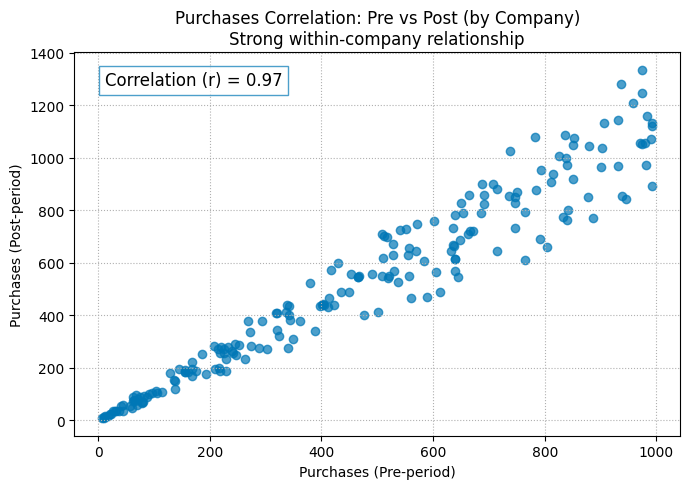

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# Get average purchases per company in Pre and Post for each company (Test+Control)
pre = df[df['Period'] == 'Pre'].groupby('Company ID')['Purchases'].mean()
post = df[df['Period'] == 'Post'].groupby('Company ID')['Purchases'].mean()
merged = pd.DataFrame({'Pre': pre, 'Post': post}).dropna()  # only companies with both periods

# Calculate correlation
corr = merged['Pre'].corr(merged['Post'])

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(merged['Pre'], merged['Post'], alpha=0.7, color="#0077b6")
plt.title("Purchases Correlation: Pre vs Post (by Company)\nStrong within-company relationship")
plt.xlabel("Purchases (Pre-period)")
plt.ylabel("Purchases (Post-period)")
plt.grid(True, linestyle=':')
plt.text(
    0.05, 0.95, f"Correlation (r) = {corr:.2f}",
    ha='left', va='top', transform=plt.gca().transAxes,
    fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='#0077b6')
)
plt.tight_layout()
plt.show()


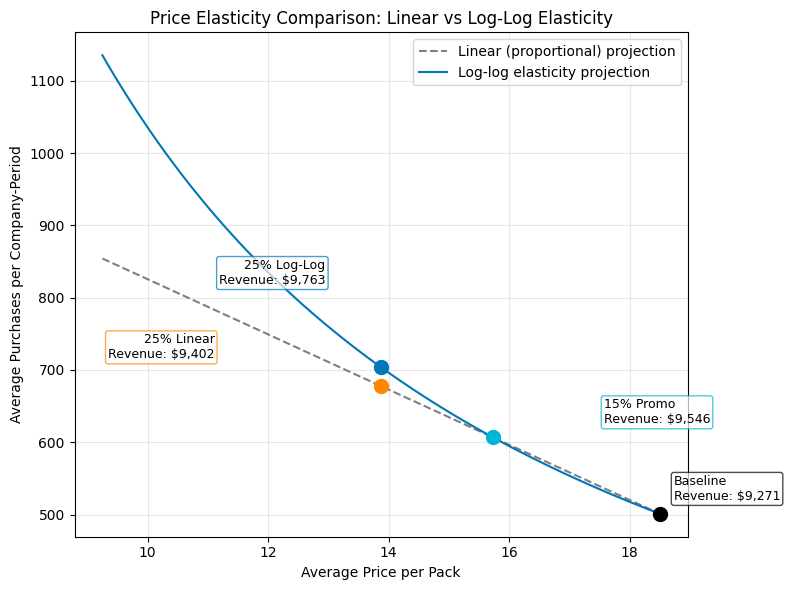

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# Baseline (Pre)
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()

# 15% Promo (Observed)
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()

# 25% off price
avg_price_25 = avg_price_baseline * 0.75

# Linear projection to 25% promo
lift_15 = avg_purchases_15 - avg_purchases_baseline
lift_25_linear = lift_15 * (25/15)
avg_purchases_25_linear = avg_purchases_baseline + lift_25_linear

# Log-log elasticity calculation
percent_price_change_log = np.log(avg_price_15 / avg_price_baseline)
percent_qty_change_log = np.log(avg_purchases_15 / avg_purchases_baseline)
elasticity = percent_qty_change_log / percent_price_change_log if percent_price_change_log != 0 else np.nan
avg_purchases_25_log = avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity

# Prepare price range and curves
prices = np.linspace(avg_price_baseline * 0.5, avg_price_baseline, 100)
m = (avg_purchases_15 - avg_purchases_baseline) / (avg_price_15 - avg_price_baseline)
linear_curve = avg_purchases_baseline + m * (prices - avg_price_baseline)
log_curve = avg_purchases_baseline * (prices / avg_price_baseline) ** elasticity

# Calculate revenue per company-period for annotation
revenue_baseline = avg_price_baseline * avg_purchases_baseline
revenue_15 = avg_price_15 * avg_purchases_15
revenue_25_linear = avg_price_25 * avg_purchases_25_linear
revenue_25_log = avg_price_25 * avg_purchases_25_log

plt.figure(figsize=(8, 6))
plt.plot(prices, linear_curve, '--', color='grey', label='Linear (proportional) projection')
plt.plot(prices, log_curve, '-', color='#0077b6', label='Log-log elasticity projection')

# Baseline
plt.scatter(avg_price_baseline, avg_purchases_baseline, s=100, color='black', zorder=5)
plt.annotate(
    f"Baseline\nRevenue: ${revenue_baseline:,.0f}",
    (avg_price_baseline, avg_purchases_baseline),
    textcoords="offset points", xytext=(10, 10),
    ha='left', fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.7)
)
# 15% promo (right)
plt.scatter(avg_price_15, avg_purchases_15, s=100, color='#00b4d8', zorder=5)
plt.annotate(
    f"15% Promo\nRevenue: ${revenue_15:,.0f}",
    (avg_price_15, avg_purchases_15),
    textcoords="offset points", xytext=(80, 10),
    ha='left', fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#00b4d8", alpha=0.7)
)
# 25% linear (left and DOWN)
plt.scatter(avg_price_25, avg_purchases_25_linear, s=100, color='#ff8800', zorder=5)
plt.annotate(
    f"25% Linear\nRevenue: ${revenue_25_linear:,.0f}",
    (avg_price_25, avg_purchases_25_linear),
    textcoords="offset points", xytext=(-120, 20),
    ha='right', fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#ff8800", alpha=0.7)
)
# 25% log-log (above)
plt.scatter(avg_price_25, avg_purchases_25_log, s=100, color='#0077b6', zorder=5)
plt.annotate(
    f"25% Log-Log\nRevenue: ${revenue_25_log:,.0f}",
    (avg_price_25, avg_purchases_25_log),
    textcoords="offset points", xytext=(-40, 60),  # ABOVE the point and curve
    ha='right', fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#0077b6", alpha=0.7)
)

plt.xlabel("Average Price per Pack")
plt.ylabel("Average Purchases per Company-Period")
plt.title("Price Elasticity Comparison: Linear vs Log-Log Elasticity")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
pre = df[df['Period'] == 'Pre']
pre['group'] = pre['Test Cohort']

# Regression: Purchases ~ Test Cohort (pre-period only)
pre_trend_model = smf.ols('Purchases ~ group', data=pre)
pre_trend_res = pre_trend_model.fit()
group_effect = pre_trend_res.params.get('group[T.Test]', np.nan)
group_pval = pre_trend_res.pvalues.get('group[T.Test]', np.nan)

print("\n=== Pre-Trend Test (Pre-period Only) ===")
print(f"Test group vs. Control effect (pre): {group_effect:.3f}, p={group_pval:.3f}")
if group_pval > 0.05:
    print("→ No significant pre-period difference: Parallel trends assumption reasonable.")
else:
    print("→ Significant pre-period difference: DiD assumption may be questionable.")



=== Pre-Trend Test (Pre-period Only) ===
Test group vs. Control effect (pre): 71.500, p=0.092
→ No significant pre-period difference: Parallel trends assumption reasonable.


/tmp/ipython-input-58-1561310281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['group'] = pre['Test Cohort']


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm

# Load your dataset
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

# Rename column to remove space
df.rename(columns={'Pack Views': 'Pack_Views'}, inplace=True)

# Mark variables for DiD
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

power_analysis = TTestIndPower()

def run_did_analysis(df, outcome_var):
    model = smf.ols(f'{outcome_var} ~ treated + post + did', data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})
    did_coef = result.params['did']
    did_se = result.bse['did']
    pval = result.pvalues['did']
    ci_low, ci_high = result.conf_int().loc['did']
    pooled_sd = df[outcome_var].std()
    n = df[(df['treated']==1) & (df['post']==0)].shape[0]
    cohen_d = did_coef / pooled_sd if pooled_sd != 0 else np.nan
    power = power_analysis.power(effect_size=cohen_d, nobs1=n, ratio=1.0, alpha=0.05) if n > 1 else np.nan
    return {
        'DiD Coefficient': did_coef,
        'SE (clustered)': did_se,
        'p-value': pval,
        '95% CI': (ci_low, ci_high),
        "Cohen's d": cohen_d,
        'Power': power
    }

# Run for Purchases
purchases_results = run_did_analysis(df, 'Purchases')
cohen_key = "Cohen's d"
print("=== 15% Promo (Aggregate DiD, Clustered SE): Purchases ===")
print(f"DiD Coefficient: {purchases_results['DiD Coefficient']:.3f}")
print(f"SE (clustered): {purchases_results['SE (clustered)']:.3f}")
print(f"p-value: {purchases_results['p-value']:.3f}")
print(f"95% CI: [{purchases_results['95% CI'][0]:.3f}, {purchases_results['95% CI'][1]:.3f}]")
print(f"Effect size (Cohen's d): {purchases_results[cohen_key]:.3f}")
print(f"Power: {purchases_results['Power']:.3f}")

# Run for Pack Views
pack_views_results = run_did_analysis(df, 'Pack_Views')
print("\n=== 15% Promo (Aggregate DiD, Clustered SE): Pack Views ===")
print(f"DiD Coefficient: {pack_views_results['DiD Coefficient']:.3f}")
print(f"SE (clustered): {pack_views_results['SE (clustered)']:.3f}")
print(f"p-value: {pack_views_results['p-value']:.3f}")
print(f"95% CI: [{pack_views_results['95% CI'][0]:.3f}, {pack_views_results['95% CI'][1]:.3f}]")
print(f"Effect size (Cohen's d): {pack_views_results[cohen_key]:.3f}")
print(f"Power: {pack_views_results['Power']:.3f}")


=== 15% Promo (Aggregate DiD, Clustered SE): Purchases ===
DiD Coefficient: 109.010
SE (clustered): 10.204
p-value: 0.000
95% CI: [89.010, 129.010]
Effect size (Cohen's d): 0.338
Power: 0.661

=== 15% Promo (Aggregate DiD, Clustered SE): Pack Views ===
DiD Coefficient: 638.000
SE (clustered): 79.009
p-value: 0.000
95% CI: [483.145, 792.855]
Effect size (Cohen's d): 0.218
Power: 0.336


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load Data
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

# Run clustered DiD regression (as in your analysis)
model = smf.ols('Purchases ~ treated + post + did', data=df)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})

# Extract point estimate and CI
did_point = result.params['did']
ci_low, ci_high = result.conf_int().loc['did']

# Get group means for log-log calculation
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
ctrl_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre')]
ctrl_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post')]

avg_price_pre = test_pre['Promotion Pack Price'].mean()
avg_purchases_pre = test_pre['Purchases'].mean()
avg_price_post = test_post['Promotion Pack Price'].mean()
avg_purchases_post = test_post['Purchases'].mean()
ctrl_pre_mean = ctrl_pre['Purchases'].mean()
ctrl_post_mean = ctrl_post['Purchases'].mean()

# Compute log changes for DiD elasticity at lower/point/upper bounds
def get_elasticity(did_effect, avg_purchases_pre, avg_purchases_post, ctrl_pre_mean, ctrl_post_mean, avg_price_pre, avg_price_post):
    # Adjust post-promo mean using the given DiD effect
    # DiD = (test_post - test_pre) - (ctrl_post - ctrl_pre)
    # So, test_post = test_pre + (ctrl_post - ctrl_pre) + DiD
    adj_avg_purchases_post = avg_purchases_pre + (ctrl_post_mean - ctrl_pre_mean) + did_effect
    log_trend_test = np.log(adj_avg_purchases_post / avg_purchases_pre) if avg_purchases_pre > 0 and adj_avg_purchases_post > 0 else 0
    log_trend_ctrl = np.log(ctrl_post_mean / ctrl_pre_mean) if ctrl_pre_mean > 0 and ctrl_post_mean > 0 else 0
    log_trend_did = log_trend_test - log_trend_ctrl
    pct_price_change_log = np.log(avg_price_post / avg_price_pre) if avg_price_pre > 0 and avg_price_post > 0 else 0
    elasticity = log_trend_did / pct_price_change_log if pct_price_change_log != 0 else np.nan
    return elasticity

elasticity_lo = get_elasticity(ci_low, avg_purchases_pre, avg_purchases_post, ctrl_pre_mean, ctrl_post_mean, avg_price_pre, avg_price_post)
elasticity_pt = get_elasticity(did_point, avg_purchases_pre, avg_purchases_post, ctrl_pre_mean, ctrl_post_mean, avg_price_pre, avg_price_post)
elasticity_hi = get_elasticity(ci_high, avg_purchases_pre, avg_purchases_post, ctrl_pre_mean, ctrl_post_mean, avg_price_pre, avg_price_post)

# Project 25% promo purchases using each elasticity
avg_price_25 = avg_price_pre * 0.75

def forecast_25pct(avg_purchases_pre, avg_price_pre, avg_price_25, elasticity):
    return avg_purchases_pre * (avg_price_25 / avg_price_pre) ** elasticity if avg_price_pre > 0 and not np.isnan(elasticity) else np.nan

pred_25_lo = forecast_25pct(avg_purchases_pre, avg_price_pre, avg_price_25, elasticity_lo)
pred_25_pt = forecast_25pct(avg_purchases_pre, avg_price_pre, avg_price_25, elasticity_pt)
pred_25_hi = forecast_25pct(avg_purchases_pre, avg_price_pre, avg_price_25, elasticity_hi)

print("\n=== 25% Promo Purchase Projection (Range based on 95% CI of 15% DiD) ===")
print(f"Lower bound (worst case):  {pred_25_lo:.2f} purchases per company-period")
print(f"Point estimate:           {pred_25_pt:.2f} purchases per company-period")
print(f"Upper bound (best case):  {pred_25_hi:.2f} purchases per company-period")

print("\nElasticity values used:")
print(f"  Lower bound: {elasticity_lo:.3f}")
print(f"  Point estimate: {elasticity_pt:.3f}")
print(f"  Upper bound: {elasticity_hi:.3f}")

print("\nInterpretation:")
print("These forecasts provide a plausible range for the 25% promo impact based on the uncertainty in the 15% promo observed effect. The true effect is likely to fall within this range (if the log-log DiD model holds).")



=== 25% Promo Purchase Projection (Range based on 95% CI of 15% DiD) ===
Lower bound (worst case):  671.66 purchases per company-period
Point estimate:           712.70 purchases per company-period
Upper bound (best case):  754.79 purchases per company-period

Elasticity values used:
  Lower bound: -1.018
  Point estimate: -1.224
  Upper bound: -1.424

Interpretation:
These forecasts provide a plausible range for the 25% promo impact based on the uncertainty in the 15% promo observed effect. The true effect is likely to fall within this range (if the log-log DiD model holds).


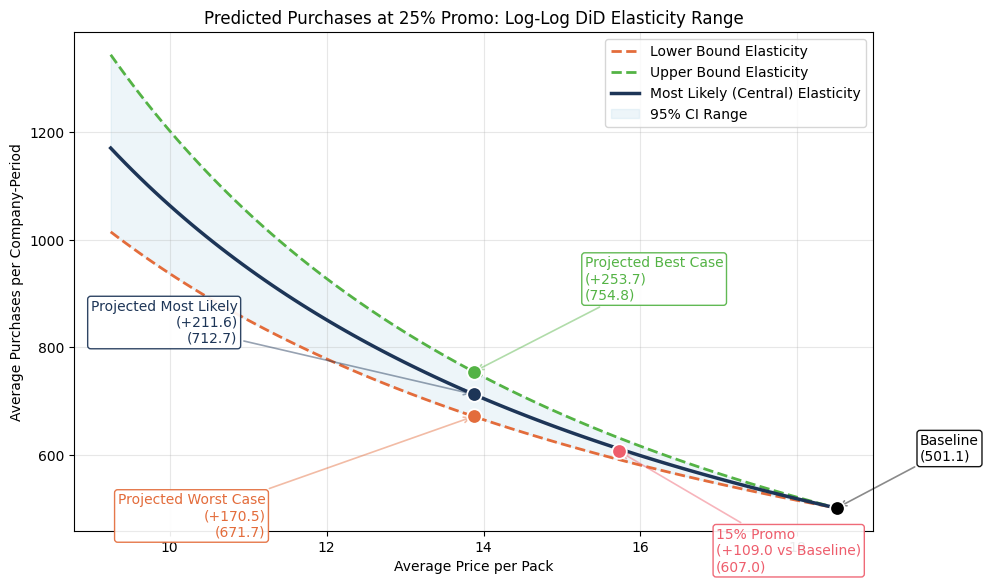

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. LOAD DATA
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

# 2. RUN DiD REGRESSION (clustered SE)
model = smf.ols('Purchases ~ treated + post + did', data=df)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})

did_coef = result.params['did']
did_se = result.bse['did']
ci_low, ci_high = result.conf_int().loc['did']

# 3. GROUP MEANS
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
control_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre')]
control_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()
ctrl_pre_mean = control_pre['Purchases'].mean()
ctrl_post_mean = control_post['Purchases'].mean()

# 4. LOG-LOG DiD ELASTICITY FROM DiD EFFECT (and CI bounds)
def elasticity_from_did(did_effect):
    control_delta = ctrl_post_mean - ctrl_pre_mean
    adj_test_post = avg_purchases_baseline + control_delta + did_effect
    pct_price_change_log = np.log(avg_price_15 / avg_price_baseline)
    if avg_purchases_baseline > 0 and adj_test_post > 0 and ctrl_pre_mean > 0 and ctrl_post_mean > 0 and pct_price_change_log != 0:
        log_trend_test = np.log(adj_test_post / avg_purchases_baseline)
        log_trend_ctrl = np.log(ctrl_post_mean / ctrl_pre_mean)
        log_trend_did = log_trend_test - log_trend_ctrl
        elasticity = log_trend_did / pct_price_change_log
        return elasticity
    else:
        return np.nan

elasticity_central = elasticity_from_did(did_coef)
elasticity_low = elasticity_from_did(ci_low)
elasticity_high = elasticity_from_did(ci_high)

avg_price_25 = avg_price_baseline * 0.75

def purchases_projected(elasticity):
    return avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity

y_25_central = purchases_projected(elasticity_central)
y_25_low = purchases_projected(elasticity_low)
y_25_high = purchases_projected(elasticity_high)

prices = np.linspace(avg_price_baseline * 0.5, avg_price_baseline, 100)
def curve(elasticity):
    return avg_purchases_baseline * (prices / avg_price_baseline) ** elasticity

curve_central = curve(elasticity_central)
curve_low = curve(elasticity_low)
curve_high = curve(elasticity_high)

# 5. PLOT
plt.figure(figsize=(10, 6))
plt.plot(prices, curve_low, color='#E36C3B', linestyle='--', linewidth=2, label='Lower Bound Elasticity')
plt.plot(prices, curve_high, color='#54B345', linestyle='--', linewidth=2, label='Upper Bound Elasticity')
plt.plot(prices, curve_central, color='#1D3557', linewidth=2.5, label='Most Likely (Central) Elasticity')
plt.fill_between(prices, curve_low, curve_high, color='#A6CEE3', alpha=0.2, label='95% CI Range')

# DiD incremental impact for each
did_impact_15 = did_coef
did_impact_25_central = y_25_central - avg_purchases_baseline
did_impact_25_low = y_25_low - avg_purchases_baseline
did_impact_25_high = y_25_high - avg_purchases_baseline

# Place each label at a different corner relative to its point
label_positions = [
    {'xytext': (60, 32), 'ha': 'left', 'va': 'bottom'},   # Baseline
    {'xytext': (70, -55), 'ha': 'left', 'va': 'top'},     # 15% Promo
    {'xytext': (-170, 35), 'ha': 'right', 'va': 'bottom'},# Projected Most Likely
    {'xytext': (-150, -55), 'ha': 'right', 'va': 'top'},  # Projected Worst Case (moved left)
    {'xytext': (80, 50), 'ha': 'left', 'va': 'bottom'},   # Projected Best Case
]
points = [
    (avg_price_baseline, avg_purchases_baseline, 'Baseline', 'black', 0, f"Baseline\n({avg_purchases_baseline:.1f})"),
    (avg_price_15, avg_purchases_15, '15% Promo', '#EE5D6C', did_impact_15, f"15% Promo\n(+{did_impact_15:.1f} vs Baseline)\n({avg_purchases_15:.1f})"),
    (avg_price_25, y_25_central, 'Projected Most Likely', '#1D3557', did_impact_25_central, f"Projected Most Likely\n(+{did_impact_25_central:.1f})\n({y_25_central:.1f})"),
    (avg_price_25, y_25_low, 'Projected Worst Case', '#E36C3B', did_impact_25_low, f"Projected Worst Case\n(+{did_impact_25_low:.1f})\n({y_25_low:.1f})"),
    (avg_price_25, y_25_high, 'Projected Best Case', '#54B345', did_impact_25_high, f"Projected Best Case\n(+{did_impact_25_high:.1f})\n({y_25_high:.1f})"),
]

for (px, py, label, color, _, text), annopos in zip(points, label_positions):
    plt.scatter(px, py, color=color, s=110, zorder=6, edgecolor='white', linewidth=1.3)
    plt.annotate(
        text,
        (px, py),
        textcoords='offset points',
        xytext=annopos['xytext'],
        ha=annopos['ha'], va=annopos['va'],
        color=color,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.22", fc="white", ec=color, alpha=0.92),
        arrowprops=dict(arrowstyle='->', lw=1.2, color=color, alpha=0.46)
    )

plt.xlabel('Average Price per Pack')
plt.ylabel('Average Purchases per Company-Period')
plt.title('Predicted Purchases at 25% Promo: Log-Log DiD Elasticity Range')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Net Revenue per Company-Period for Each Scenario:
Baseline:           9270.72
15% Promo:          9545.55  (Change: +274.83)
25% Promo (Worst):  9319.30  (Change: +48.58)
25% Promo (Likely): 9888.70  (Change: +617.98)
25% Promo (Best):   10472.73  (Change: +1202.01)


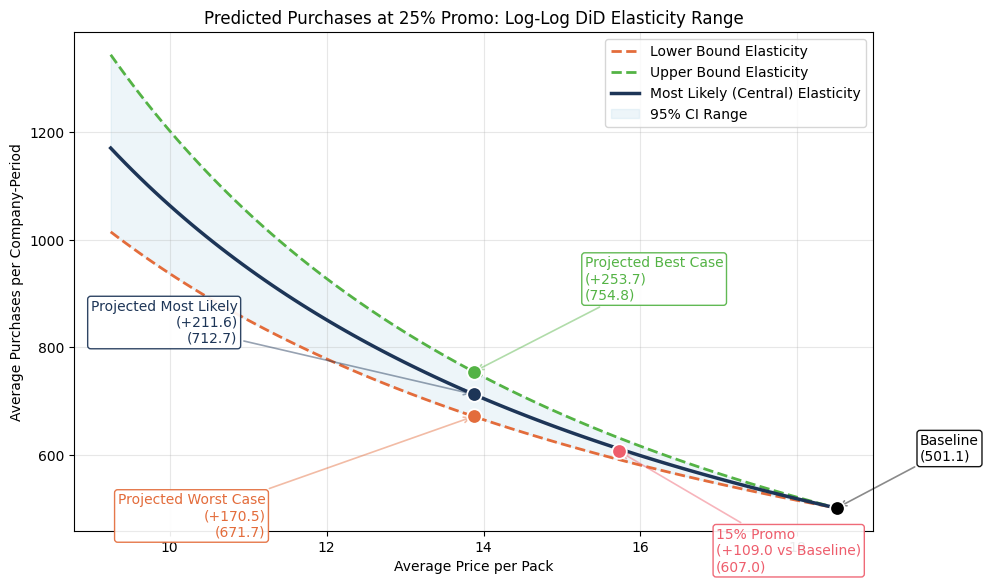

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. LOAD DATA
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

# 2. RUN DiD REGRESSION (clustered SE)
model = smf.ols('Purchases ~ treated + post + did', data=df)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})

did_coef = result.params['did']
did_se = result.bse['did']
ci_low, ci_high = result.conf_int().loc['did']

# 3. GROUP MEANS
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
control_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre')]
control_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()
ctrl_pre_mean = control_pre['Purchases'].mean()
ctrl_post_mean = control_post['Purchases'].mean()

# 4. LOG-LOG DiD ELASTICITY FROM DiD EFFECT (and CI bounds)
def elasticity_from_did(did_effect):
    control_delta = ctrl_post_mean - ctrl_pre_mean
    adj_test_post = avg_purchases_baseline + control_delta + did_effect
    pct_price_change_log = np.log(avg_price_15 / avg_price_baseline)
    if avg_purchases_baseline > 0 and adj_test_post > 0 and ctrl_pre_mean > 0 and ctrl_post_mean > 0 and pct_price_change_log != 0:
        log_trend_test = np.log(adj_test_post / avg_purchases_baseline)
        log_trend_ctrl = np.log(ctrl_post_mean / ctrl_pre_mean)
        log_trend_did = log_trend_test - log_trend_ctrl
        elasticity = log_trend_did / pct_price_change_log
        return elasticity
    else:
        return np.nan

elasticity_central = elasticity_from_did(did_coef)
elasticity_low = elasticity_from_did(ci_low)
elasticity_high = elasticity_from_did(ci_high)

avg_price_25 = avg_price_baseline * 0.75

def purchases_projected(elasticity):
    return avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity

y_25_central = purchases_projected(elasticity_central)
y_25_low = purchases_projected(elasticity_low)
y_25_high = purchases_projected(elasticity_high)

prices = np.linspace(avg_price_baseline * 0.5, avg_price_baseline, 100)
def curve(elasticity):
    return avg_purchases_baseline * (prices / avg_price_baseline) ** elasticity

curve_central = curve(elasticity_central)
curve_low = curve(elasticity_low)
curve_high = curve(elasticity_high)

# 5. CALCULATE REVENUES FOR EACH SCENARIO (added)
revenue_baseline = avg_price_baseline * avg_purchases_baseline
revenue_15 = avg_price_15 * avg_purchases_15
revenue_25_central = avg_price_25 * y_25_central
revenue_25_low = avg_price_25 * y_25_low
revenue_25_high = avg_price_25 * y_25_high

# 6. PRINT NET REVENUE RESULTS (added)
print("\nNet Revenue per Company-Period for Each Scenario:")
print(f"Baseline:           {revenue_baseline:.2f}")
print(f"15% Promo:          {revenue_15:.2f}  (Change: {revenue_15 - revenue_baseline:+.2f})")
print(f"25% Promo (Worst):  {revenue_25_low:.2f}  (Change: {revenue_25_low - revenue_baseline:+.2f})")
print(f"25% Promo (Likely): {revenue_25_central:.2f}  (Change: {revenue_25_central - revenue_baseline:+.2f})")
print(f"25% Promo (Best):   {revenue_25_high:.2f}  (Change: {revenue_25_high - revenue_baseline:+.2f})")

# 7. PLOT
plt.figure(figsize=(10, 6))
plt.plot(prices, curve_low, color='#E36C3B', linestyle='--', linewidth=2, label='Lower Bound Elasticity')
plt.plot(prices, curve_high, color='#54B345', linestyle='--', linewidth=2, label='Upper Bound Elasticity')
plt.plot(prices, curve_central, color='#1D3557', linewidth=2.5, label='Most Likely (Central) Elasticity')
plt.fill_between(prices, curve_low, curve_high, color='#A6CEE3', alpha=0.2, label='95% CI Range')

# DiD incremental impact for each
did_impact_15 = did_coef
did_impact_25_central = y_25_central - avg_purchases_baseline
did_impact_25_low = y_25_low - avg_purchases_baseline
did_impact_25_high = y_25_high - avg_purchases_baseline

# Place each label at a different corner relative to its point
label_positions = [
    {'xytext': (60, 32), 'ha': 'left', 'va': 'bottom'},   # Baseline
    {'xytext': (70, -55), 'ha': 'left', 'va': 'top'},     # 15% Promo
    {'xytext': (-170, 35), 'ha': 'right', 'va': 'bottom'},# Projected Most Likely
    {'xytext': (-150, -55), 'ha': 'right', 'va': 'top'},  # Projected Worst Case (moved left)
    {'xytext': (80, 50), 'ha': 'left', 'va': 'bottom'},   # Projected Best Case
]
points = [
    (avg_price_baseline, avg_purchases_baseline, 'Baseline', 'black', 0, f"Baseline\n({avg_purchases_baseline:.1f})"),
    (avg_price_15, avg_purchases_15, '15% Promo', '#EE5D6C', did_impact_15, f"15% Promo\n(+{did_impact_15:.1f} vs Baseline)\n({avg_purchases_15:.1f})"),
    (avg_price_25, y_25_central, 'Projected Most Likely', '#1D3557', did_impact_25_central, f"Projected Most Likely\n(+{did_impact_25_central:.1f})\n({y_25_central:.1f})"),
    (avg_price_25, y_25_low, 'Projected Worst Case', '#E36C3B', did_impact_25_low, f"Projected Worst Case\n(+{did_impact_25_low:.1f})\n({y_25_low:.1f})"),
    (avg_price_25, y_25_high, 'Projected Best Case', '#54B345', did_impact_25_high, f"Projected Best Case\n(+{did_impact_25_high:.1f})\n({y_25_high:.1f})"),
]

for (px, py, label, color, _, text), annopos in zip(points, label_positions):
    plt.scatter(px, py, color=color, s=110, zorder=6, edgecolor='white', linewidth=1.3)
    plt.annotate(
        text,
        (px, py),
        textcoords='offset points',
        xytext=annopos['xytext'],
        ha=annopos['ha'], va=annopos['va'],
        color=color,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.22", fc="white", ec=color, alpha=0.92),
        arrowprops=dict(arrowstyle='->', lw=1.2, color=color, alpha=0.46)
    )

plt.xlabel('Average Price per Pack')
plt.ylabel('Average Purchases per Company-Period')
plt.title('Predicted Purchases at 25% Promo: Log-Log DiD Elasticity Range')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Net Revenue per Company-Period for Each Scenario:
Baseline:           9270.72
15% Promo:          9545.55  (Change: +274.83)
25% Promo (Worst):  9319.30  (Change: +48.58)
25% Promo (Likely): 9888.70  (Change: +617.98)
25% Promo (Best):   10472.73  (Change: +1202.01)


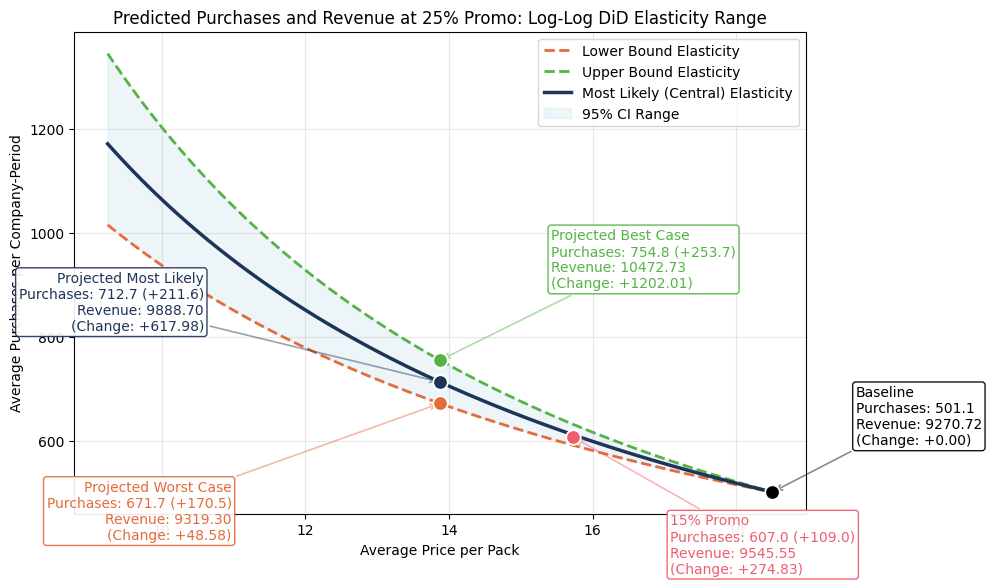

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. LOAD DATA
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

# 2. RUN DiD REGRESSION (clustered SE)
model = smf.ols('Purchases ~ treated + post + did', data=df)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})

did_coef = result.params['did']
did_se = result.bse['did']
ci_low, ci_high = result.conf_int().loc['did']

# 3. GROUP MEANS
test_pre = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Pre')]
test_post = df[(df['Test Cohort'] == 'Test') & (df['Period'] == 'Post')]
control_pre = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Pre')]
control_post = df[(df['Test Cohort'] == 'Control') & (df['Period'] == 'Post')]
avg_price_baseline = test_pre['Promotion Pack Price'].mean()
avg_purchases_baseline = test_pre['Purchases'].mean()
avg_price_15 = test_post['Promotion Pack Price'].mean()
avg_purchases_15 = test_post['Purchases'].mean()
ctrl_pre_mean = control_pre['Purchases'].mean()
ctrl_post_mean = control_post['Purchases'].mean()

# 4. LOG-LOG DiD ELASTICITY FROM DiD EFFECT (and CI bounds)
def elasticity_from_did(did_effect):
    control_delta = ctrl_post_mean - ctrl_pre_mean
    adj_test_post = avg_purchases_baseline + control_delta + did_effect
    pct_price_change_log = np.log(avg_price_15 / avg_price_baseline)
    if avg_purchases_baseline > 0 and adj_test_post > 0 and ctrl_pre_mean > 0 and ctrl_post_mean > 0 and pct_price_change_log != 0:
        log_trend_test = np.log(adj_test_post / avg_purchases_baseline)
        log_trend_ctrl = np.log(ctrl_post_mean / ctrl_pre_mean)
        log_trend_did = log_trend_test - log_trend_ctrl
        elasticity = log_trend_did / pct_price_change_log
        return elasticity
    else:
        return np.nan

elasticity_central = elasticity_from_did(did_coef)
elasticity_low = elasticity_from_did(ci_low)
elasticity_high = elasticity_from_did(ci_high)

avg_price_25 = avg_price_baseline * 0.75

def purchases_projected(elasticity):
    return avg_purchases_baseline * (avg_price_25 / avg_price_baseline) ** elasticity

y_25_central = purchases_projected(elasticity_central)
y_25_low = purchases_projected(elasticity_low)
y_25_high = purchases_projected(elasticity_high)

prices = np.linspace(avg_price_baseline * 0.5, avg_price_baseline, 100)
def curve(elasticity):
    return avg_purchases_baseline * (prices / avg_price_baseline) ** elasticity

curve_central = curve(elasticity_central)
curve_low = curve(elasticity_low)
curve_high = curve(elasticity_high)

# 5. CALCULATE REVENUES FOR EACH SCENARIO
revenue_baseline = avg_price_baseline * avg_purchases_baseline
revenue_15 = avg_price_15 * avg_purchases_15
revenue_25_central = avg_price_25 * y_25_central
revenue_25_low = avg_price_25 * y_25_low
revenue_25_high = avg_price_25 * y_25_high

# 6. PRINT NET REVENUE RESULTS
print("\nNet Revenue per Company-Period for Each Scenario:")
print(f"Baseline:           {revenue_baseline:.2f}")
print(f"15% Promo:          {revenue_15:.2f}  (Change: {revenue_15 - revenue_baseline:+.2f})")
print(f"25% Promo (Worst):  {revenue_25_low:.2f}  (Change: {revenue_25_low - revenue_baseline:+.2f})")
print(f"25% Promo (Likely): {revenue_25_central:.2f}  (Change: {revenue_25_central - revenue_baseline:+.2f})")
print(f"25% Promo (Best):   {revenue_25_high:.2f}  (Change: {revenue_25_high - revenue_baseline:+.2f})")

# 7. PLOT with revenue change in labels, numbers labeled explicitly
plt.figure(figsize=(10, 6))
plt.plot(prices, curve_low, color='#E36C3B', linestyle='--', linewidth=2, label='Lower Bound Elasticity')
plt.plot(prices, curve_high, color='#54B345', linestyle='--', linewidth=2, label='Upper Bound Elasticity')
plt.plot(prices, curve_central, color='#1D3557', linewidth=2.5, label='Most Likely (Central) Elasticity')
plt.fill_between(prices, curve_low, curve_high, color='#A6CEE3', alpha=0.2, label='95% CI Range')

# DiD incremental impact for each
did_impact_15 = did_coef
did_impact_25_central = y_25_central - avg_purchases_baseline
did_impact_25_low = y_25_low - avg_purchases_baseline
did_impact_25_high = y_25_high - avg_purchases_baseline

# Add revenue delta to annotation text, numbers labeled for purchases & revenue
points = [
    (avg_price_baseline, avg_purchases_baseline, 'Baseline', 'black', 0,
     f"Baseline\nPurchases: {avg_purchases_baseline:.1f}\nRevenue: {revenue_baseline:.2f}\n(Change: +0.00)"),
    (avg_price_15, avg_purchases_15, '15% Promo', '#EE5D6C', did_impact_15,
     f"15% Promo\nPurchases: {avg_purchases_15:.1f} (+{did_impact_15:.1f})\nRevenue: {revenue_15:.2f}\n(Change: {revenue_15 - revenue_baseline:+.2f})"),
    (avg_price_25, y_25_central, 'Projected Most Likely', '#1D3557', did_impact_25_central,
     f"Projected Most Likely\nPurchases: {y_25_central:.1f} (+{did_impact_25_central:.1f})\nRevenue: {revenue_25_central:.2f}\n(Change: {revenue_25_central - revenue_baseline:+.2f})"),
    (avg_price_25, y_25_low, 'Projected Worst Case', '#E36C3B', did_impact_25_low,
     f"Projected Worst Case\nPurchases: {y_25_low:.1f} (+{did_impact_25_low:.1f})\nRevenue: {revenue_25_low:.2f}\n(Change: {revenue_25_low - revenue_baseline:+.2f})"),
    (avg_price_25, y_25_high, 'Projected Best Case', '#54B345', did_impact_25_high,
     f"Projected Best Case\nPurchases: {y_25_high:.1f} (+{did_impact_25_high:.1f})\nRevenue: {revenue_25_high:.2f}\n(Change: {revenue_25_high - revenue_baseline:+.2f})"),
]

label_positions = [
    {'xytext': (60, 32), 'ha': 'left', 'va': 'bottom'},   # Baseline
    {'xytext': (70, -55), 'ha': 'left', 'va': 'top'},     # 15% Promo
    {'xytext': (-170, 35), 'ha': 'right', 'va': 'bottom'},# Projected Most Likely
    {'xytext': (-150, -55), 'ha': 'right', 'va': 'top'},  # Projected Worst Case
    {'xytext': (80, 50), 'ha': 'left', 'va': 'bottom'},   # Projected Best Case
]

for (px, py, label, color, _, text), annopos in zip(points, label_positions):
    plt.scatter(px, py, color=color, s=110, zorder=6, edgecolor='white', linewidth=1.3)
    plt.annotate(
        text,
        (px, py),
        textcoords='offset points',
        xytext=annopos['xytext'],
        ha=annopos['ha'], va=annopos['va'],
        color=color,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.22", fc="white", ec=color, alpha=0.92),
        arrowprops=dict(arrowstyle='->', lw=1.2, color=color, alpha=0.46)
    )

plt.xlabel('Average Price per Pack')
plt.ylabel('Average Purchases per Company-Period')
plt.title('Predicted Purchases and Revenue at 25% Promo: Log-Log DiD Elasticity Range')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm

# === Load Data ===
file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)

df['treated'] = (df['Test Cohort'] == 'Test').astype(int)
df['post'] = (df['Period'] == 'Post').astype(int)
df['did'] = df['treated'] * df['post']

def run_did_analysis(df, outcome_var):
    model = smf.ols(f'Q("{outcome_var}") ~ treated + post + did', data=df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df['Company ID']})
    did_coef = result.params['did']
    did_se = result.bse['did']
    pval = result.pvalues['did']
    ci_low, ci_high = result.conf_int().loc['did']
    pooled_sd = df[outcome_var].std()
    n = df[(df['treated']==1) & (df['post']==0)].shape[0]
    power_analysis = TTestIndPower()
    cohen_d = did_coef / pooled_sd if pooled_sd != 0 else np.nan
    power = power_analysis.power(effect_size=cohen_d, nobs1=n, ratio=1.0, alpha=0.05) if n > 1 else np.nan
    return {
        'DiD Coefficient': did_coef,
        'SE (clustered)': did_se,
        'p-value': pval,
        '95% CI': (ci_low, ci_high),
        'Cohen_d': cohen_d,         # changed key (no apostrophe)
        'Power': power
    }

def print_results(title, res, digits=3):
    print(f"\n=== 15% Promo (Aggregate DiD, Clustered SE): {title} ===")
    print(f"DiD Coefficient: {res['DiD Coefficient']:.{digits}f}")
    print(f"SE (clustered): {res['SE (clustered)']:.{digits}f}")
    print(f"p-value: {res['p-value']:.3f}")
    print(f"95% CI: [{res['95% CI'][0]:.{digits}f}, {res['95% CI'][1]:.{digits}f}]")
    print(f"Effect size (Cohen's d): {res['Cohen_d']:.3f}")
    print(f"Power: {res['Power']:.3f}")

# === Run for Purchases ===
purchases_results = run_did_analysis(df, 'Purchases')
print_results('Purchases', purchases_results)

# === Run for Pack Views ===
pack_views_results = run_did_analysis(df, 'Pack Views')
print_results('Pack Views', pack_views_results)

# === Conversion Rate: Purchases / Pack Views ===
df['conversion'] = df['Purchases'] / df['Pack Views']
df['conversion'] = df['conversion'].replace([np.inf, -np.inf], np.nan).fillna(0)
conversion_results = run_did_analysis(df, 'conversion')
print_results('Conversion Rate (Purchases per Pack View)', conversion_results)

# --- Additional Insights ---
print("\nAdditional Insights (pre/post group means):")
for var in ['Purchases', 'Pack Views', 'conversion']:
    pre = df[(df['treated']==1) & (df['post']==0)][var].mean()
    post = df[(df['treated']==1) & (df['post']==1)][var].mean()
    print(f"{var}: Test Pre = {pre:.3f}, Test Post = {post:.3f}, Δ = {post-pre:.3f}")



=== 15% Promo (Aggregate DiD, Clustered SE): Purchases ===
DiD Coefficient: 109.010
SE (clustered): 10.204
p-value: 0.000
95% CI: [89.010, 129.010]
Effect size (Cohen's d): 0.338
Power: 0.661

=== 15% Promo (Aggregate DiD, Clustered SE): Pack Views ===
DiD Coefficient: 638.000
SE (clustered): 79.009
p-value: 0.000
95% CI: [483.145, 792.855]
Effect size (Cohen's d): 0.218
Power: 0.336

=== 15% Promo (Aggregate DiD, Clustered SE): Conversion Rate (Purchases per Pack View) ===
DiD Coefficient: 0.012
SE (clustered): 0.004
p-value: 0.002
95% CI: [0.004, 0.019]
Effect size (Cohen's d): 0.081
Power: 0.088

Additional Insights (pre/post group means):
Purchases: Test Pre = 501.120, Test Post = 607.030, Δ = 105.910
Pack Views: Test Pre = 5594.840, Test Post = 6321.380, Δ = 726.540
conversion: Test Pre = 0.124, Test Post = 0.133, Δ = 0.009


In [13]:
import pandas as pd

file_path = 'Sr_Analyst_Pricing_Take_Home_-_Candidate_Copy_(1).xlsx'
df = pd.read_excel(file_path)
corr = df[['Pack Views', 'Purchases']].corr().loc['Pack Views', 'Purchases']
print(f"Correlation between Pack Views and Purchases: {corr:.3f}")


Correlation between Pack Views and Purchases: 0.165
